# Pedro Ribeiro

O desafio é **desenvolver uma solução para agrupar clientes baseado nos seus perfis de gastos**.
Para atingir esse objetivo, serão executados os seguintes passos:

1. Realizar uma análise exploratória profunda dos dados para entender as características e padrões de gastos dos clientes.
2. Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.
3. Utilizar técnicas de clustering para segmentar os clientes em diferentes perfis de gastos.
4. Com base na análise exploratória, etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra (como alimentação, saúde, lazer, etc.).
5. Responder às seguintes perguntas:
   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
   - Quais as categorias de compra que mais impactam nos perfis de gasto?
   - Quais são os perfis centrais (ou típicos) de cada cluster?

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\pedro\AppData\Local\Temp\ipykernel_27476\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Libraries

In [2]:
import os
import re
import pandas as pd
from datetime import date
from dotenv import load_dotenv

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from scipy.stats import f_oneway

import pickle

import warnings
warnings.filterwarnings('ignore')

# Dataframes

In [3]:
#Usando variável de ambiente para guardar o caminho do dataframe local
load_dotenv(".env")
path_dir = os.environ.get('path_dir')

In [4]:
os.chdir(path_dir)

In [5]:
accounts = pd.read_csv(os.getcwd()+'/data/accounts.csv')
display(accounts.head())
person = pd.read_csv(os.getcwd()+'/data/person.csv')
display(person.head())
transactions = pd.read_csv(os.getcwd()+'/data/transactions.csv')
display(transactions.head())

,id,type,subtype,balance,currency_code,name,person_id,account_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,dcd96f70-8b16-42b0-a944-afec5d8305ce,2023-09-09 03:38:49
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,6c2a44fe-2ba7-4626-aaff-f244a0647eae,2023-09-12 14:21:21
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,BRL,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,abb359a2-3802-48e7-976b-8671e1de0884,2023-09-12 04:10:04


,id,name,suitability
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo


,id,currency_code,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


In [6]:
# Verificar o sinal de cada uma das variáveis no intuido de entender se faz sentido retirar o valor de negativo
print('Saída', transactions[transactions.amount < 0].category.unique())
print('Entrada', transactions[transactions.amount > 0].category.unique())
print('Zero', transactions[transactions.amount == 0].category.unique())

Saída ['Educação' 'Outras saídas' 'Transporte' 'Imposto, juros e multa'
 'Alimentação' nan 'Saúde' 'Moradia' 'Compras' 'Lazer']
Entrada ['Investimento' 'Recebido']
Zero []


In [7]:
are_columns_equal = accounts['id'].equals(accounts['account_id'])
are_columns_equal

True

In [8]:
print(accounts.currency_code.unique())
print(transactions.currency_code.unique())

['BRL']
['BRL']


In [9]:
# Retirar colunas 'currency_code', pois só possui o valor 'BRL'
# Retirar colunas 'account_id', pois os valores são iguais a da coluna 'id'
accounts.drop('currency_code', axis='columns', inplace=True)
accounts.drop('account_id', axis='columns', inplace=True)
transactions.drop('currency_code', axis='columns', inplace=True)

In [10]:
accounts['date_acc'] = pd.to_datetime(accounts['date']).map(lambda x:x.date())
accounts.drop('date', axis='columns', inplace=True)
transactions['date_trans'] = pd.to_datetime(transactions['date']).map(lambda x:x.date())
transactions.drop('date', axis='columns', inplace=True)

In [11]:
# Verificando se existe algum valor nulo
transactions_null = transactions[transactions.category.isnull()]
transactions_null[transactions_null.amount>0]

,id,amount,category,account_id,date_trans


In [12]:
# Tranformação de todos os gastos em valores positivos 
# pois a coluna 'category' já indica que os valores são negaticos
transactions['amount'] = transactions['amount'].map(lambda x:abs(x))

In [13]:
# Verificando como está o nome dos clientes
def has_non_letter(string):
    pattern = r'[^a-zA-Záàâãéèêíïóôõöúçñ\s]'
    return bool(re.search(pattern, string))

strings = person.name

for string in strings:
    if has_non_letter(string):
        print(f"{string}")
    pass

Dr. Gustavo Henrique Viana
Sr. Erick Rezende
Dr. Lucca Moraes
Srta. Rebeca da Rocha
Srta. Maria Fernanda Castro
Sr. Otávio Porto
Srta. Sophia Pereira
Dra. Rafaela Barros
Dra. Sarah Freitas
Srta. Lívia Pinto
Dra. Laís Rezende
Sra. Gabriela Nunes
Sr. Pedro Henrique Duarte
Srta. Camila Farias
Dr. Marcelo Dias
Sra. Sophia Viana
Dra. Ana Julia das Neves
Srta. Sofia Barbosa
Sra. Rebeca Pires
Dra. Beatriz Moura
Dra. Kamilly Martins
Dra. Gabrielly Novaes
Dr. Cauê Silva
Sr. Yago Costa
Srta. Caroline Almeida
Dra. Júlia Silveira
Sra. Maria Vitória Caldeira
Sra. Marcela Lima
Sra. Ana das Neves
Dra. Maria Cecília Oliveira
Sra. Alícia Oliveira
Srta. Eduarda Ferreira
Dra. Maria Cecília Ribeiro
Sra. Marina Ribeiro
Dr. Breno Freitas
Sr. João Pedro Duarte
Dra. Rebeca Moura
Srta. Maysa Jesus
Dr. Yuri Teixeira
Sr. Thomas da Cruz
Sra. Alana Freitas
Srta. Ana Beatriz da Rosa
Sra. Raquel Fogaça
Dr. Pietro Rodrigues
Dr. Noah Rocha
Dr. Renan Barbosa
Sra. Pietra da Conceição
Dr. João Felipe Freitas
Dr. Henrique

In [14]:
# Retirando os pronomes dos nome dos clientes no intuito de limpar os dados  
person['person_name'] = person['name'].apply(lambda x: x.split(". ")[1] if x.startswith("Dr. ") or x.startswith("Dra. ") or x.startswith("Sr. ") or x.startswith("Sra. ") or 
                                             x.startswith("Srta. ") else x)

In [15]:
strings = person.person_name

for string in strings:
    if has_non_letter(string):
        print(f"{string}")
    pass

In [16]:
display(accounts.head())
display(person.head())
display(transactions.head())

,id,type,subtype,balance,name,person_id,date_acc
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12


,id,name,suitability,person_name
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo,Emilly Moura
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador,Luiz Miguel Caldeira
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador,Sarah Souza
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo,Samuel Oliveira


,id,amount,category,account_id,date_trans
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20
1,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23
2,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05


# Exploratory analysis

### Análise Exploratória de Dados - Univariada

Primeiramente irei realizar uma análise exploratóiria para cada variável de cada um dos datasets separadamente para entender o comportamento geral e verificar valores faltantes

### Person

In [17]:
person.shape

(2531, 4)

In [18]:
person.dtypes

id             object
name           object
suitability    object
person_name    object
dtype: object

In [19]:
person.isnull().sum()

id               0
name             0
suitability    447
person_name      0
dtype: int64

In [20]:
display(person.head())
display(person.tail())

,id,name,suitability,person_name
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo,Emilly Moura
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador,Luiz Miguel Caldeira
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador,Sarah Souza
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo,Samuel Oliveira


,id,name,suitability,person_name
2526,39f66a6b-1a60-4ee5-b186-3c0e7400004b,Kevin da Conceição,conservador,Kevin da Conceição
2527,5050325b-5bcd-40a3-a6ac-5f14ada7dc5b,Lara da Mota,agressivo,Lara da Mota
2528,480997ba-051c-46b1-90d1-c5e99686351d,Sr. Guilherme Peixoto,moderado,Guilherme Peixoto
2529,526c75ce-fcc9-405a-8e6a-15b6c9cde719,Enzo Nascimento,NaN,Enzo Nascimento
2530,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira


In [21]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2531 non-null   object
 1   name         2531 non-null   object
 2   suitability  2084 non-null   object
 3   person_name  2531 non-null   object
dtypes: object(4)
memory usage: 79.2+ KB


In [22]:
person.duplicated().sum()

0

In [23]:
# Tabela contendo os dados que tem valores nulos na coluna 'suitability'
filtered_null_suitability = person[person['suitability'].isnull()]
filtered_null_suitability

,id,name,suitability,person_name
13,6af9c508-a57a-43cb-9ab3-2aecf18f5cea,Ana Beatriz Jesus,NaN,Ana Beatriz Jesus
14,cf0c52f9-5542-495d-b1f3-02b83366c861,Lavínia Farias,NaN,Lavínia Farias
16,3b273d75-dbc5-4b87-9cf0-1fe0587b349c,Luiz Otávio Azevedo,NaN,Luiz Otávio Azevedo
32,1ce95f5d-eaf8-464c-9809-e98eb44bebf2,Maria Julia Silva,NaN,Maria Julia Silva
34,d3f7da64-ef01-441f-9cbd-7c22534f586c,Srta. Rebeca da Rocha,NaN,Rebeca da Rocha
...,...,...,...,...
2505,197280f3-84a2-4167-bab4-bd7f7375abce,Luiz Felipe Rocha,NaN,Luiz Felipe Rocha
2507,069ea8f2-f744-4aeb-a320-fb576c50229b,Otávio Cunha,NaN,Otávio Cunha
2520,b50fa919-195d-479b-911d-efc9889ca4c1,Breno Lopes,NaN,Breno Lopes
2521,9717e592-5fcc-4f58-8b69-5602e79fc16f,André Peixoto,NaN,André Peixoto


In [24]:
print(f"The dataframe has {len(filtered_null_suitability)} missing values in the suitability of a total of {len(person)}: {round((len(filtered_null_suitability)/len(person)*100),1)}%")

The dataframe has 447 missing values in the suitability of a total of 2531: 17.7%


In [25]:
person['suitability'].fillna("no_suitability", inplace=True)

no_suitability          447
agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

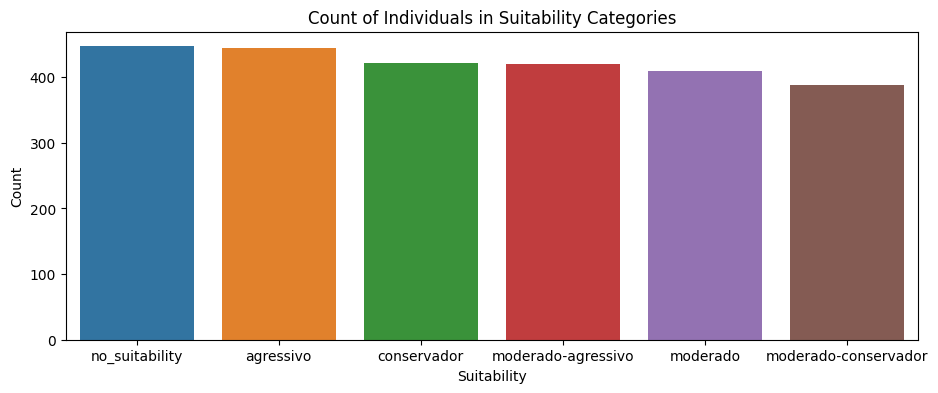

In [26]:
display(person["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person["suitability"].value_counts().values, 
            x=person["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

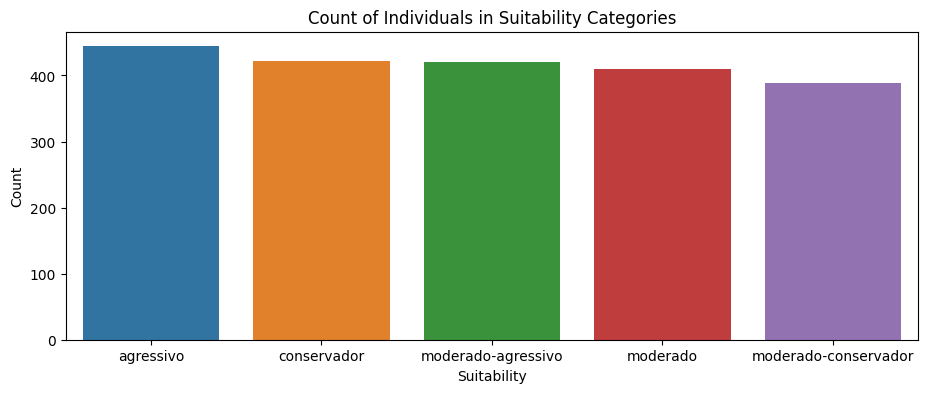

In [27]:
# Os dados de contagem de suitability estão relativamente pareados
display(person[person["suitability"] != "no_suitability"]["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().values, 
            x=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

In [28]:
print("""
Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o melhor será utilizar o id de 
identificação de cada cliente pois é único
""")
person.describe()


Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o melhor será utilizar o id de 
identificação de cada cliente pois é único



,id,name,suitability,person_name
count,2531,2531,2531,2531
unique,2531,2374,6,2313
top,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Felipe Peixoto,no_suitability,Ana Castro
freq,1,3,447,3


### Accounts

In [29]:
accounts.shape

(7569, 7)

In [30]:
accounts.dtypes

id            object
type          object
subtype       object
balance      float64
name          object
person_id     object
date_acc      object
dtype: object

In [31]:
accounts.isnull().sum()

id           0
type         0
subtype      0
balance      0
name         0
person_id    0
date_acc     0
dtype: int64

In [32]:
display(accounts.head())
display(accounts.tail())

,id,type,subtype,balance,name,person_id,date_acc
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12


,id,type,subtype,balance,name,person_id,date_acc
7564,88f496c6-eac6-422f-8a4d-e88ca3fe0351,BANK,SAVINGS_ACCOUNT,12044.12,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15
7565,e3ca889d-2b1c-464a-be4f-b7719822ba98,CREDIT,CREDIT_CARD,12351.60,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-14
7566,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,CREDIT,CREDIT_CARD,9555.10,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-08-29
7567,8c709383-2d35-4796-995f-3eea8e7fefd9,CREDIT,CREDIT_CARD,5044.89,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15
7568,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15


In [33]:
accounts.info()
# Não possuem valores Null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7569 non-null   object 
 1   type       7569 non-null   object 
 2   subtype    7569 non-null   object 
 3   balance    7569 non-null   float64
 4   name       7569 non-null   object 
 5   person_id  7569 non-null   object 
 6   date_acc   7569 non-null   object 
dtypes: float64(1), object(6)
memory usage: 414.1+ KB


In [34]:
# Verificando duplicidade nos dados
accounts.duplicated().sum()

0

In [35]:
accounts.columns

Index(['id', 'type', 'subtype', 'balance', 'name', 'person_id', 'date_acc'], dtype='object')

In [36]:
print("max", accounts.date_acc.max())
print("min", accounts.date_acc.min())

max 2023-09-15
min 2023-06-20


2023/9    7199
2023/8     302
2023/7      58
2023/6      10
Name: year_month_acc, dtype: int64

9    7199
8     302
7      58
6      10
Name: date_acc, dtype: int64

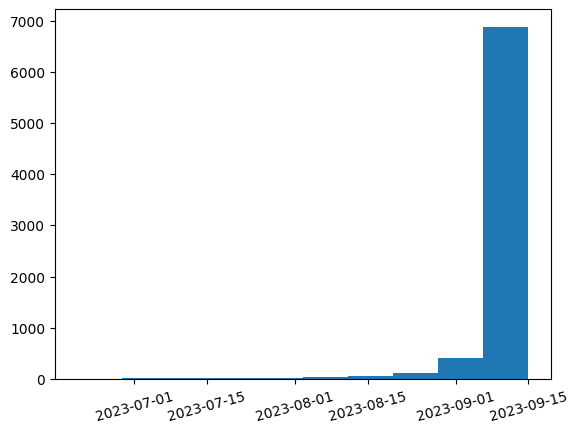

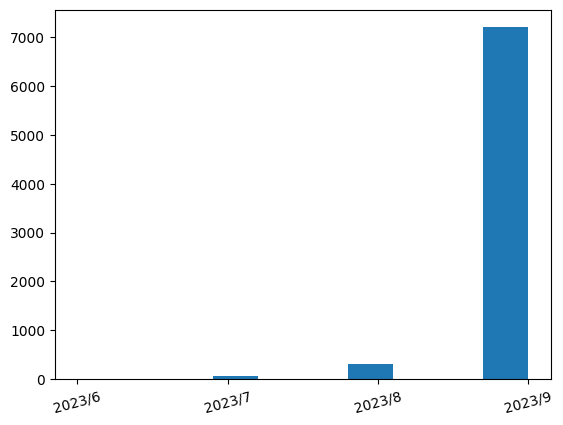

In [37]:
# Distribuição das datas
accounts['year_month_acc'] = accounts.date_acc.map(lambda x:str(x.year))+"/"+accounts.date_acc.map(lambda x:str(x.month))
display(accounts['year_month_acc'].value_counts())

display(accounts.date_acc.map(lambda x:x.month).value_counts())

plt.hist(accounts.date_acc, bins=10)
plt.xticks(rotation=15)
plt.show()

plt.hist(accounts.year_month_acc.sort_values(), bins=10)
plt.xticks(rotation=15)
plt.show()

In [38]:
accounts.describe()

,balance
count,7569.000000
mean,5717.472539
std,4825.408916
min,11.520000
25%,2514.880000
50%,5021.490000
75%,7558.410000
max,44965.250000


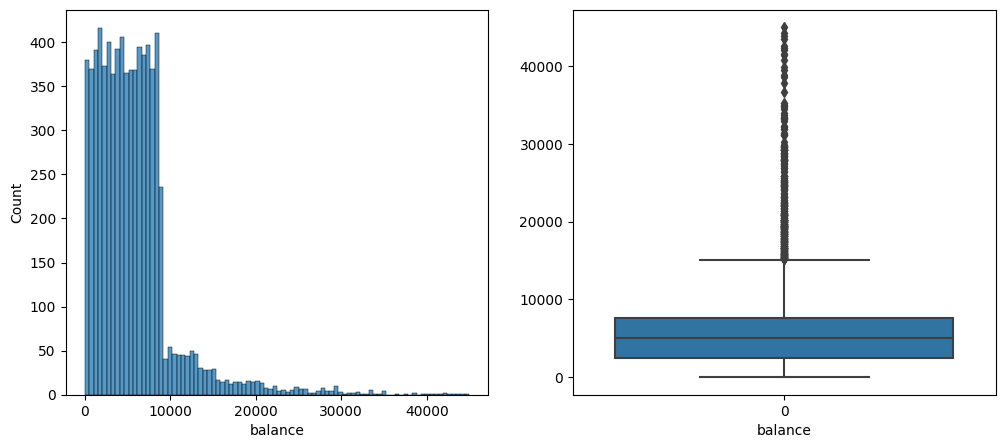

In [39]:
# Distribuição do 'balance'
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2)

# Plot o histograma
sns.histplot(accounts.balance, ax = fig.add_subplot(gs[0, 0]))
plt.xlabel('balance')
# Plot a boxplot 
sns.boxplot(accounts.balance, ax = fig.add_subplot(gs[0, 1]))
plt.xlabel('balance')

plt.show()

BANK      4950
CREDIT    2619
Name: type, dtype: int64

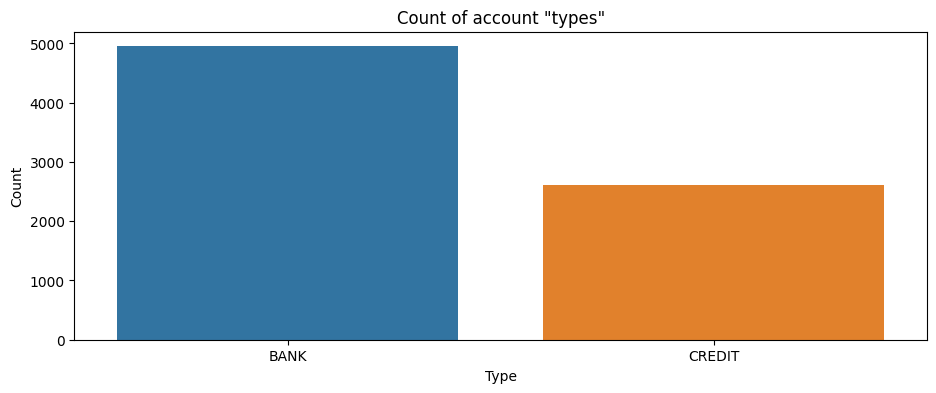

In [40]:
display(accounts["type"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["type"].value_counts().values, x=accounts["type"].value_counts().index)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of account "types"')
plt.show()

CREDIT_CARD         2619
CHECKING_ACCOUNT    2509
SAVINGS_ACCOUNT     2441
Name: subtype, dtype: int64

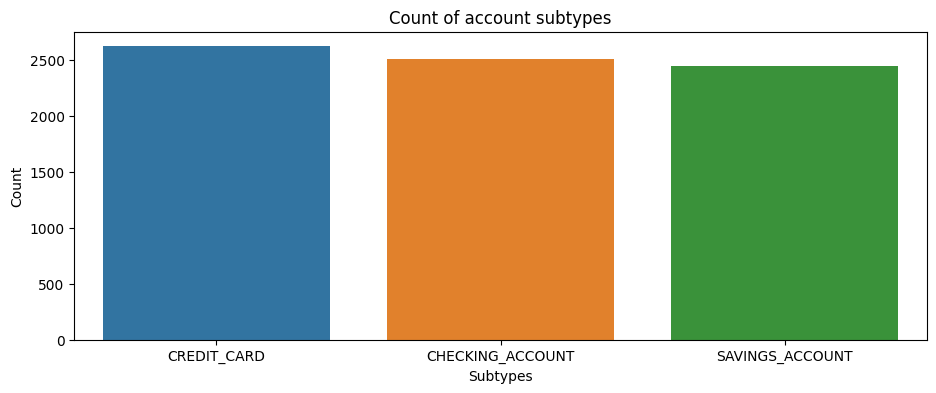

In [41]:
display(accounts["subtype"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["subtype"].value_counts().values, x=accounts["subtype"].value_counts().index)
plt.xlabel('Subtypes')
plt.ylabel('Count')
plt.title('Count of account subtypes')
plt.show()

Cartão de Crédito    2619
Conta Corrente       2509
Poupança              845
Conta Remunerada      804
Caixinha              792
Name: name, dtype: int64

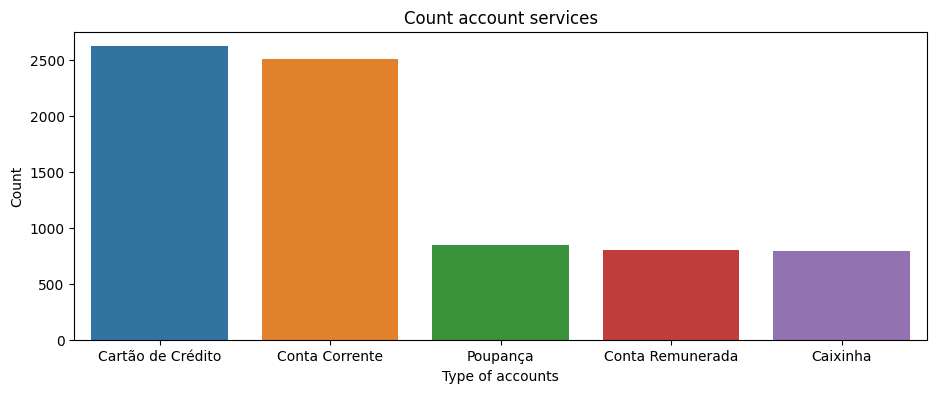

In [42]:
display(accounts["name"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["name"].value_counts().values, x=accounts["name"].value_counts().index)
plt.xlabel('Type of accounts')
plt.ylabel('Count')
plt.title('Count account services')
plt.show()

### Transactions

In [43]:
transactions.shape

(400110, 5)

In [44]:
transactions.dtypes

id             object
amount        float64
category       object
account_id     object
date_trans     object
dtype: object

In [45]:
# Verificando linhas duplicadas
transactions.duplicated().sum()

0

In [46]:
# Verificando valores nulos
transactions.isnull().sum()

id                0
amount            0
category      31609
account_id        0
date_trans        0
dtype: int64

In [47]:
transactions.describe()

,amount
count,400110.000000
mean,1192.511743
std,1692.519860
min,10.100000
25%,216.900000
50%,592.110000
75%,1553.435000
max,29334.350000


In [48]:
display(transactions.head())
display(transactions.tail())

,id,amount,category,account_id,date_trans
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20
1,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23
2,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05


,id,amount,category,account_id,date_trans
400105,95d79cc9-988c-4811-81f8-ffe910092074,2185.20,Recebido,df03df9a-b7e3-4ee3-b2d5-50275e41afcf,2022-12-02
400106,eac2684b-c13b-44c2-8efb-79fbf9c4cd75,2274.47,Recebido,7dbe31db-bad3-4820-91c1-94e85a44a7aa,2023-07-22
400107,f1452582-06f3-47ce-bb13-2a2adb8a6cbe,7328.84,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81,2023-07-24
400108,1db037b4-fe8c-48f5-92f0-10c753f5330f,7328.84,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81,2023-06-25
400109,c2b4de56-d6bc-4b4f-b7c5-4c0aea79a129,5081.83,Recebido,1d6c9df7-a0aa-4435-a6a9-97590c05d52c,2023-06-17


In [49]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          400110 non-null  object 
 1   amount      400110 non-null  float64
 2   category    368501 non-null  object 
 3   account_id  400110 non-null  object 
 4   date_trans  400110 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.3+ MB


In [50]:
print("max", transactions.date_trans.max())
print("min", transactions.date_trans.min())

max 2023-09-15
min 2022-01-03


2023/7     136331
2023/8     132728
2023/6      62929
2023/9      62076
2023/5       4111
2023/4       1098
2023/3        363
2023/2        182
2023/1        117
2022/12        70
2022/11        38
2022/10        20
2022/9         16
2022/8          7
2022/7          5
2022/6          5
2022/5          3
2022/4          3
2022/3          3
2022/1          3
2022/2          2
Name: year_month_trans, dtype: int64

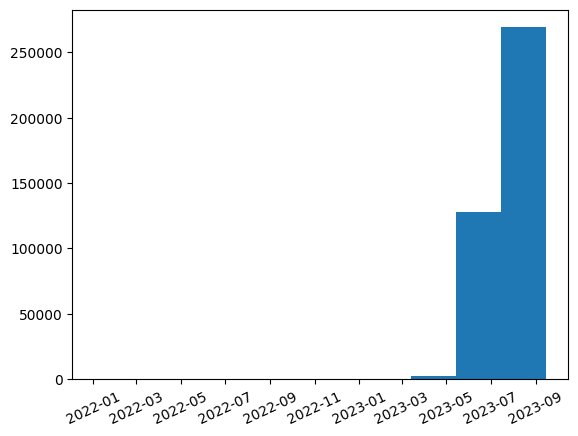

In [51]:
transactions['year_month_trans'] = transactions.date_trans.map(lambda x:str(x.year))+"/"+transactions.date_trans.map(lambda x:str(x.month))
display(transactions['year_month_trans'].value_counts())

plt.hist(transactions.date_trans, bins=10)
plt.xticks(rotation=25)
plt.show()

In [52]:
filtered_null_category = transactions[transactions['category'].isnull()]
filtered_null_category
# 31609 rows × 6 columns

,id,amount,category,account_id,date_trans,year_month_trans
8,437feea8-3afd-4f2f-9c98-91de4575b57b,1258.65,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-19,2023/6
12,ef335bda-b208-40b3-abee-46de72b5a0b3,199.70,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-22,2023/6
68,96b1c62c-e319-40e5-a201-69432b145fd3,535.54,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-16,2023/8
76,024227f9-af91-4ce0-b4e7-d6d243dd9153,2436.43,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-13,2023/9
87,c12a1b96-92d2-4541-bb85-472959819a30,1786.20,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-27,2023/8
...,...,...,...,...,...,...
380109,111d167f-9ba0-4918-a689-0db641cb8f46,7351.86,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-09-03,2023/9
380113,b6929181-a07a-42d1-a32e-6ddafc2774be,1426.42,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-08-23,2023/8
380145,52ce02f0-321e-4c30-9cdf-387aa0b67413,6277.14,NaN,8c709383-2d35-4796-995f-3eea8e7fefd9,2023-08-11,2023/8
380158,9d7623d3-9ef3-4151-ae50-6e72fee99634,4825.69,NaN,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-26,2023/7


In [53]:
print(f"The dataframe has {len(filtered_null_category)} missing values in the suitability of a total of {len(transactions)}: {round((len(filtered_null_category)/len(transactions)*100),1)}%")

The dataframe has 31609 missing values in the suitability of a total of 400110: 7.9%


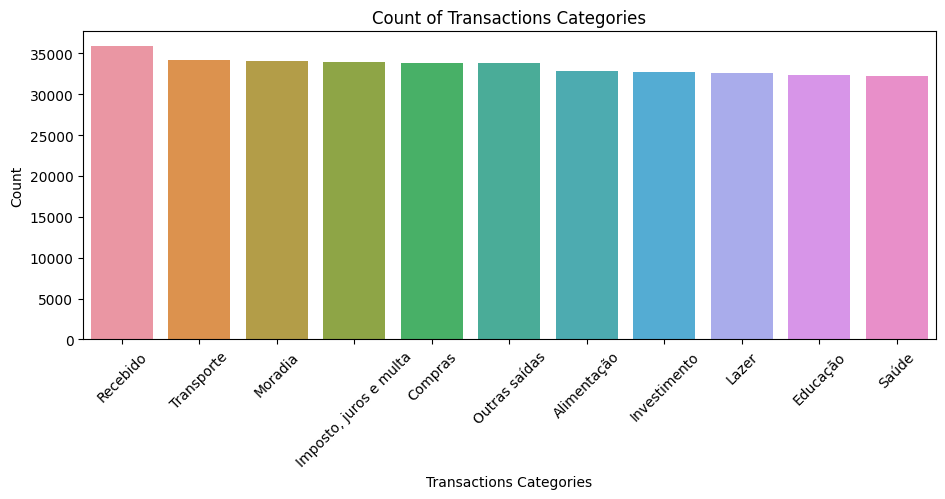

In [54]:
# Contagem de transações relativamente igual
transactions["category"].value_counts()

plt.figure(figsize=(11, 4))
sns.barplot(y=transactions["category"].value_counts().values, x=transactions["category"].value_counts().index)
plt.xlabel('Transactions Categories')
plt.ylabel('Count')
plt.title('Count of Transactions Categories')
plt.xticks(rotation=45)
plt.show()

In [55]:
# Para preencher os valores nulos da coluna 'category', verifiquei se existia algum valor semelhante em outra linha que pertencia a mesma conta

# Para isso, criei um dicionário de correspondências entre 'account_id' e 'amount'
mapping_dict = transactions.dropna(subset=['category']).drop_duplicates(subset=['account_id', 'amount']).set_index(['account_id', 'amount'])['category'].to_dict()

# Criei uma função para preencher valores nulos em 'category' com base no dicionário de correspondências
def fill_category(row):
    if pd.notna(row['category']):
        return row['category']
    account_id = row['account_id']
    amount = row['amount']
    if (account_id, amount) in mapping_dict:
        return mapping_dict[(account_id, amount)]
    return None

# Preenchendo os valores nulos em 'category' com base no dicionário de correspondências
transactions['category'] = transactions.apply(fill_category, axis=1)


In [56]:
filtered_null_category = transactions[transactions['category'].isnull()]
filtered_null_category

,id,amount,category,account_id,date_trans,year_month_trans
8,437feea8-3afd-4f2f-9c98-91de4575b57b,1258.65,None,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-19,2023/6
12,ef335bda-b208-40b3-abee-46de72b5a0b3,199.70,None,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-22,2023/6
68,96b1c62c-e319-40e5-a201-69432b145fd3,535.54,None,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-16,2023/8
76,024227f9-af91-4ce0-b4e7-d6d243dd9153,2436.43,None,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-13,2023/9
87,c12a1b96-92d2-4541-bb85-472959819a30,1786.20,None,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-27,2023/8
...,...,...,...,...,...,...
380109,111d167f-9ba0-4918-a689-0db641cb8f46,7351.86,None,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-09-03,2023/9
380113,b6929181-a07a-42d1-a32e-6ddafc2774be,1426.42,None,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-08-23,2023/8
380145,52ce02f0-321e-4c30-9cdf-387aa0b67413,6277.14,None,8c709383-2d35-4796-995f-3eea8e7fefd9,2023-08-11,2023/8
380158,9d7623d3-9ef3-4151-ae50-6e72fee99634,4825.69,None,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-26,2023/7


In [57]:
# Após a verificação anterior, para os valore nulos faltantes atribuí a categoria 'Outras saídas'
transactions['category'].fillna("Outras saídas", inplace=True)

In [58]:
filtered_null_category = transactions[transactions['category'].isnull()]
filtered_null_category

,id,amount,category,account_id,date_trans,year_month_trans


In [59]:
transactions.head()

,id,amount,category,account_id,date_trans,year_month_trans
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20,2023/7
1,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23,2023/7
2,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26,2023/6
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21,2023/6
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05,2023/8


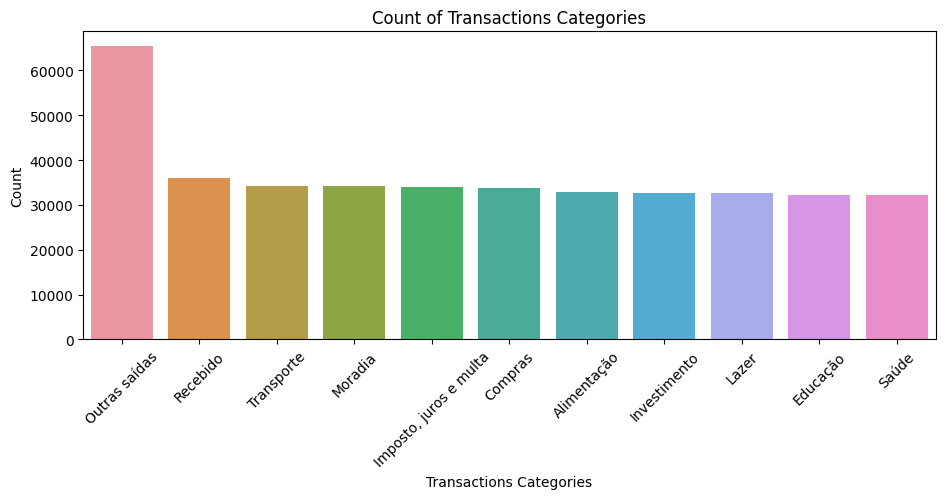

In [60]:
# Contagem de transações relativamente igual, somente os outras saídas que possuem maior número, pois adicionei os valores que não possuiam categoria definida.
transactions["category"].value_counts()

plt.figure(figsize=(11, 4))
sns.barplot(y=transactions["category"].value_counts().values, x=transactions["category"].value_counts().index)
plt.xlabel('Transactions Categories')
plt.ylabel('Count')
plt.title('Count of Transactions Categories')
plt.xticks(rotation=45)
plt.show()

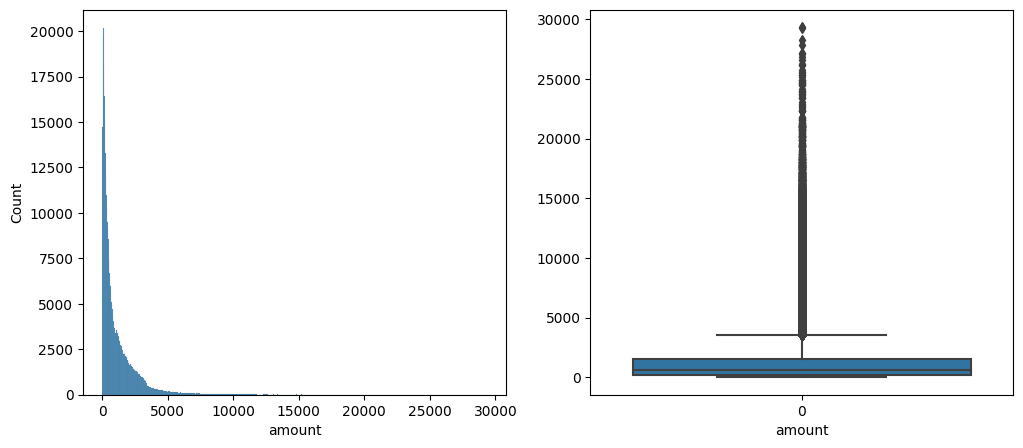

In [61]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2)

# Plotando o histogram
sns.histplot(transactions.amount, ax = fig.add_subplot(gs[0, 0]))
plt.xlabel('amount')
# Plotando o boxplot
sns.boxplot(transactions.amount, ax = fig.add_subplot(gs[0, 1]))
plt.xlabel('amount')

plt.show()

# Merge dataframes

In [62]:
person_merge = person[['id', 'suitability']]
accounts_merge = accounts[['id', 'subtype', 'balance', 'name', 'person_id', 'date_acc', "year_month_acc"]]
transactions_merge = transactions[['id', 'amount', 'date_trans', 'category', 'account_id', 'year_month_trans']]

In [63]:
merged_accounts = pd.merge(person_merge, accounts_merge, left_on="id", right_on="person_id", how="left", suffixes=("_person", "_acc"))

In [64]:
merged_accounts.head()

,id_person,suitability,id_acc,subtype,balance,name,person_id,date_acc,year_month_acc
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15,2023/9
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09,2023/9
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,6c2a44fe-2ba7-4626-aaff-f244a0647eae,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12,2023/9
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,abb359a2-3802-48e7-976b-8671e1de0884,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12,2023/9


In [65]:
merged_accounts.shape

(7569, 9)

In [66]:
merged_data_total = pd.merge(merged_accounts, transactions, left_on="id_acc", right_on="account_id", how="left", suffixes=("_acc", "_trans"))

In [67]:
merged_data_total.head()

,id_person,suitability,id_acc,subtype,balance,name,person_id,date_acc,year_month_acc,id,amount,category,account_id,date_trans,year_month_trans
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20,2023/7
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23,2023/7
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26,2023/6
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21,2023/6
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05,2023/8


In [68]:
print('merged_data_total.columns:', merged_data_total.columns)

merged_data_total.columns: Index(['id_person', 'suitability', 'id_acc', 'subtype', 'balance', 'name',
       'person_id', 'date_acc', 'year_month_acc', 'id', 'amount', 'category',
       'account_id', 'date_trans', 'year_month_trans'],
      dtype='object')


In [69]:
df_bivariado = merged_data_total[['id_person', 'id_acc', 'id', 'suitability', 'date_acc', 'year_month_acc','balance', 'name','date_trans',
                                  'year_month_trans', 'category', 'amount']]
df_bivariado = df_bivariado.rename(columns={'id': 'id_trans', 'name':'acc_type'})
print('Shape:', df_bivariado.shape)

Shape: (400110, 12)


In [70]:
display(df_bivariado.head())
display(df_bivariado.tail())

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44


,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d1297b29-1168-4f15-b856-fc252375d4f7,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-06-20,2023/6,Lazer,735.58
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,bf174dd6-91b9-4b52-b847-cf814accdb07,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-12,2023/7,Saúde,1205.81
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-27,2023/7,Saúde,921.22
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,35c6a2bd-c6d7-450a-910b-cf323b444dbf,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-23,2023/7,Compras,2767.55
400109,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d52a9f5e-840f-47f2-a9d5-5c45e6086754,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-09,2023/7,Investimento,1970.78


In [71]:
df_bivariado.describe()

,balance,amount
count,400110.000000,400110.000000
mean,5688.566108,1192.511743
std,4758.308835,1692.519860
min,11.520000,10.100000
25%,2540.750000,216.900000
50%,5045.500000,592.110000
75%,7566.560000,1553.435000
max,44965.250000,29334.350000


In [72]:
print('max_trans', df_bivariado.date_trans.max())
print('min_trans', df_bivariado.date_trans.min())

print('max_acc', df_bivariado.date_acc.max())
print('min_acc', df_bivariado.date_acc.min())

max_trans 2023-09-15
min_trans 2022-01-03
max_acc 2023-09-15
min_acc 2023-06-20


In [73]:
# verificando linhas duplicadas
df_bivariado.duplicated().sum()

0

In [74]:
df_bivariado.head()

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44


### Análise Exploratória de Dados - Bivariada

In [75]:
df_bivariado.head()

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44


In [76]:
df_bivariado.columns

Index(['id_person', 'id_acc', 'id_trans', 'suitability', 'date_acc',
       'year_month_acc', 'balance', 'acc_type', 'date_trans',
       'year_month_trans', 'category', 'amount'],
      dtype='object')

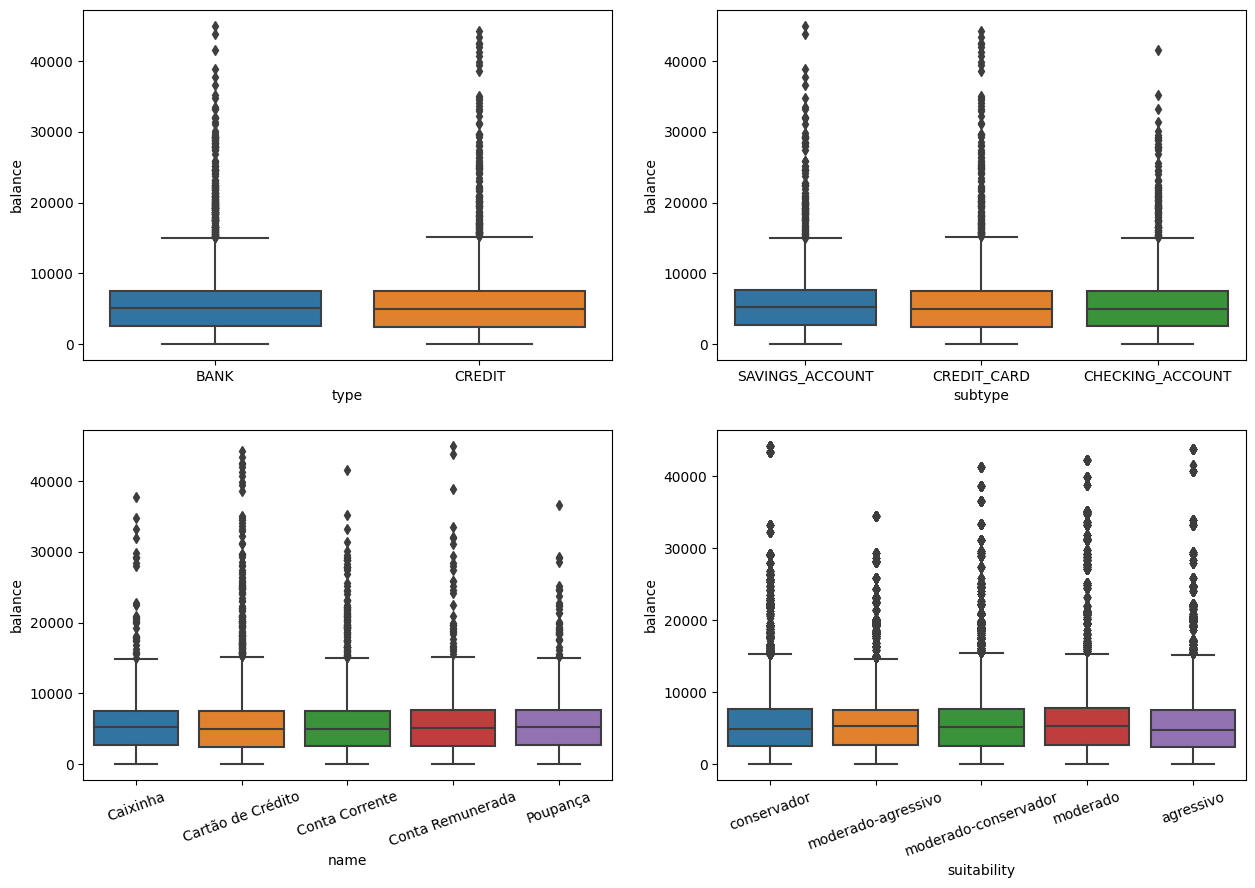

In [77]:
# Verificando a distribuição do balance para cada variável

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2)

sns.boxplot(x='type', y='balance', data=accounts, ax = fig.add_subplot(gs[0, 0]))
plt.xlabel('type')
sns.boxplot(x='subtype', y='balance', data=accounts, ax = fig.add_subplot(gs[0, 1]))
plt.xlabel('subtype')
sns.boxplot(x='name', y='balance', data=accounts, ax = fig.add_subplot(gs[1, 0]))
plt.xlabel('name')
plt.xticks(rotation=20)
sns.boxplot(x='suitability', y='balance', data=df_bivariado[df_bivariado.suitability != "no_suitability"], ax = fig.add_subplot(gs[1, 1]))
plt.xticks(rotation=20)
plt.xlabel('suitability')

plt.show()

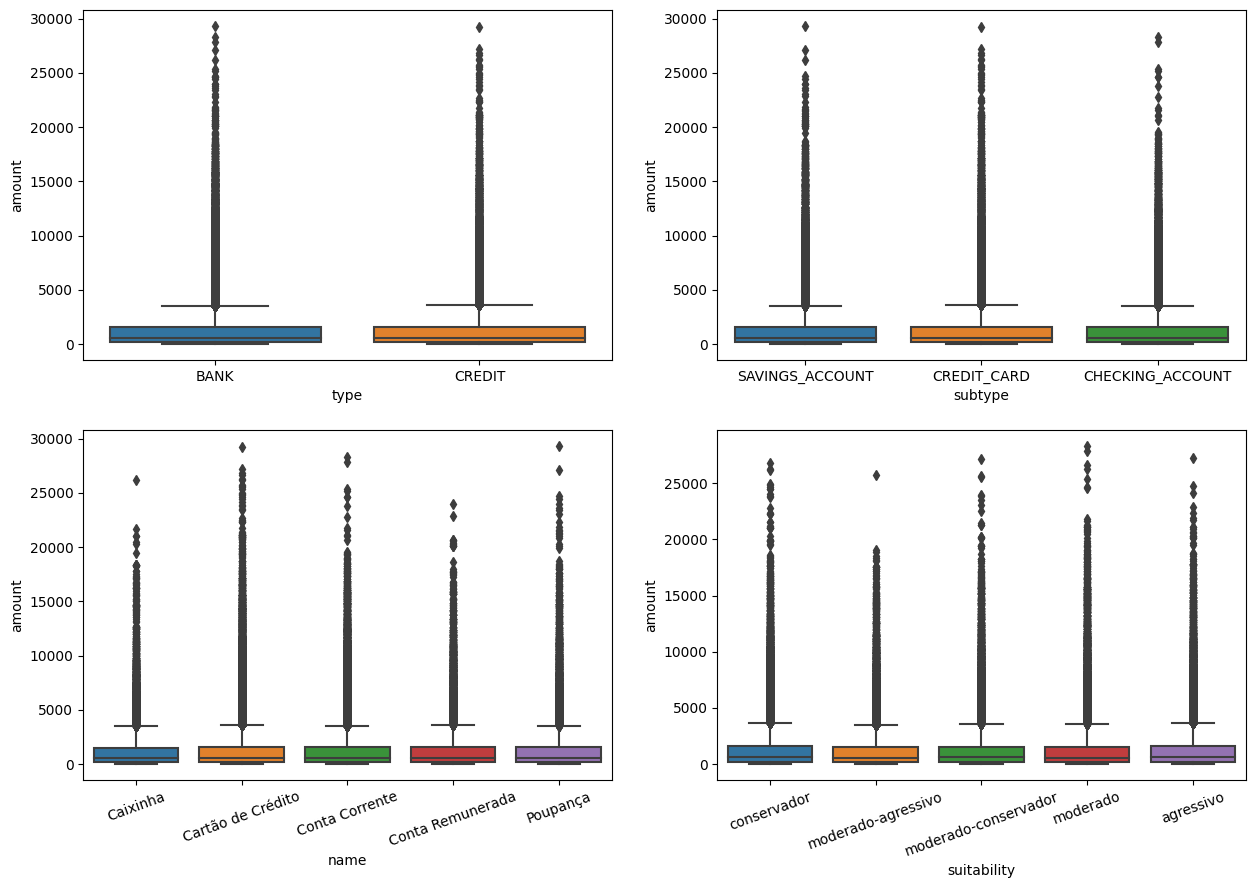

In [78]:
# Verificando a distribuição do balance para cada variável
df_bivariado_2 = pd.merge(accounts, transactions, left_on="id", right_on="account_id", how="left", suffixes=("_acc", "_trans"))
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2)

sns.boxplot(x='type', y='amount', data=df_bivariado_2, ax = fig.add_subplot(gs[0, 0]))
plt.xlabel('type')
sns.boxplot(x='subtype', y='amount', data=df_bivariado_2, ax = fig.add_subplot(gs[0, 1]))
plt.xlabel('subtype')
sns.boxplot(x='name', y='amount', data=df_bivariado_2, ax = fig.add_subplot(gs[1, 0]))
plt.xlabel('name')
plt.xticks(rotation=20)
sns.boxplot(x='suitability', y='amount', data=df_bivariado[df_bivariado.suitability != "no_suitability"], ax = fig.add_subplot(gs[1, 1]))
plt.xticks(rotation=20)
plt.xlabel('suitability')

plt.show()

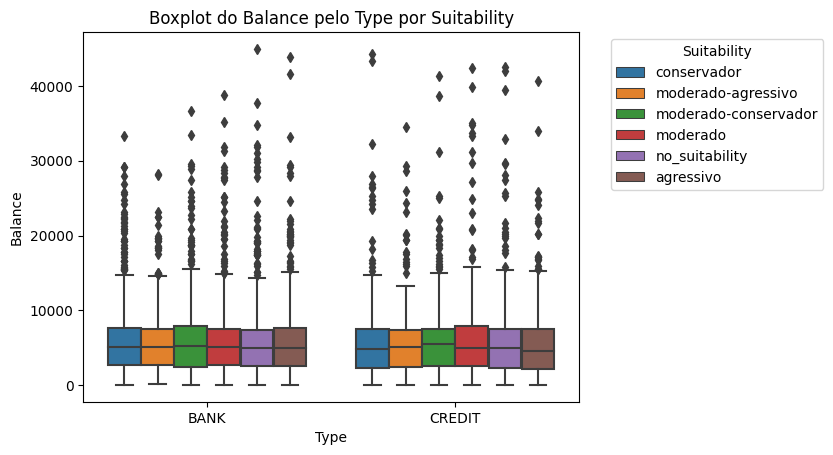

In [79]:
# Boxplot para entender a distribuição dos subtypes em relação ao "suitability"
merged_accounts_mod = pd.merge(person, accounts, left_on='id', right_on='person_id')
sns.boxplot(x='type', y='balance', data=merged_accounts_mod, hue='suitability')

plt.xlabel("Type")
plt.ylabel("Balance")
plt.title("Boxplot do Balance pelo Type por Suitability")
plt.legend(title="Suitability", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

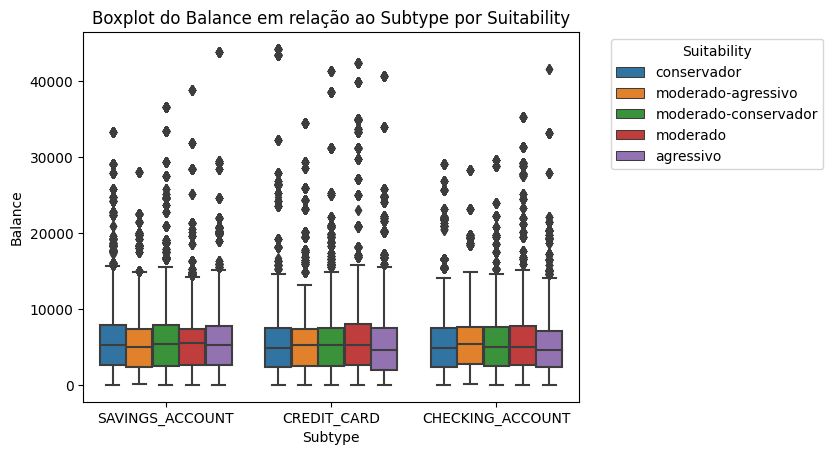

In [80]:
# Filtrando o dataframe excluindo "no_suitability" da coluna "suitability" 
merged_data_total_mod = merged_data_total[merged_data_total['suitability'] != 'no_suitability']

# Boxplot para entender a distribuição dos subtypes em relação ao "suitability"
sns.boxplot(x='subtype', y='balance', data=merged_data_total_mod, hue='suitability')

plt.xlabel("Subtype")
plt.ylabel("Balance")
plt.title("Boxplot do Balance em relação ao Subtype por Suitability")
plt.legend(title="Suitability", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

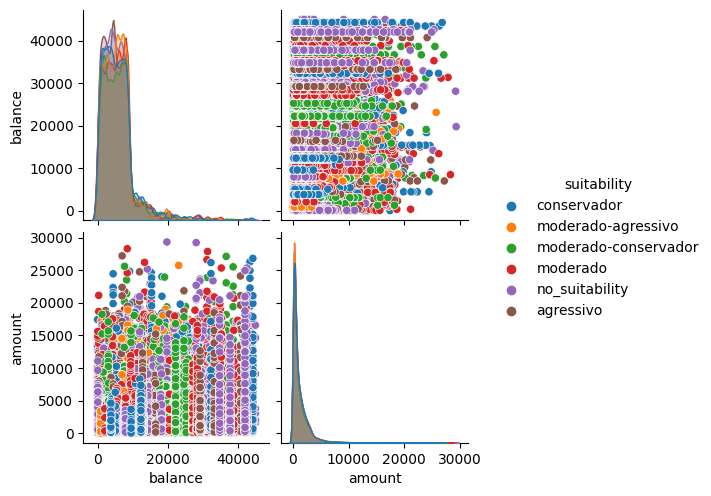

In [81]:
# Para entender a distribuição e se existe alguma relação entre as variáveis numéricas considerando cada suitability
sns.pairplot(df_bivariado, hue='suitability')

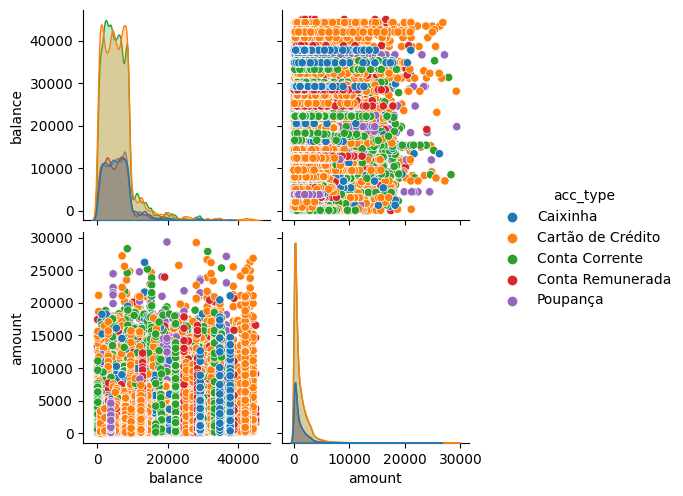

In [82]:
# Para entender a distribuição e se existe alguma relação entre as variáveis numéricas considerando cada tipo de conta
sns.pairplot(df_bivariado, hue='acc_type')

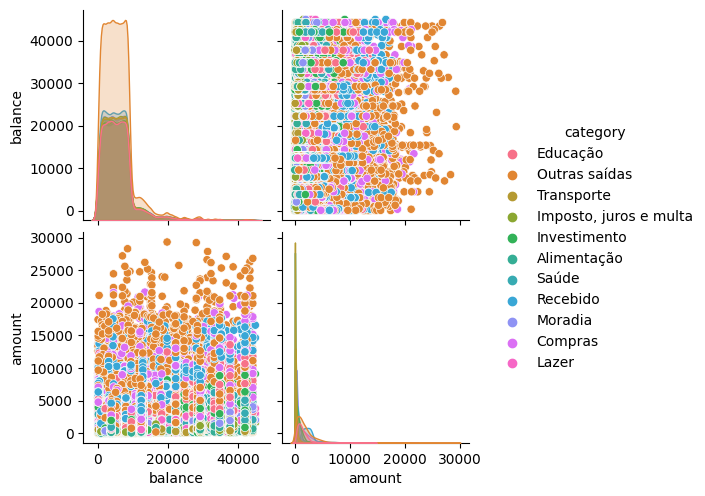

In [83]:
# Para entender a distribuição e se existe alguma relação entre as variáveis numéricas considerando cada tipo de category
sns.pairplot(df_bivariado, hue='category')

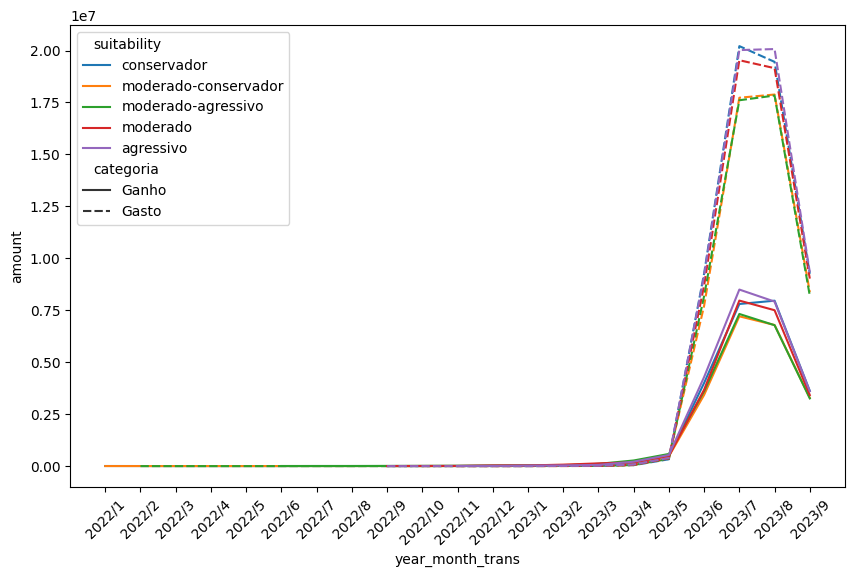

In [84]:
# Filtrando os dados para excluir 'no_suitability'
df_bivariado['year_month_full'] = pd.to_datetime(df_bivariado.year_month_trans)
df_filtered = df_bivariado[df_bivariado['suitability'] != 'no_suitability']

# Criando DataFrames separados para "Gasto" e "Recebido"
df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

# Agrupar e somar os valores
df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
df_recebidos = df_recebidos.groupby(['suitability','year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

# Adicionando uma coluna 'cat' para indicar se é gasto ou recebido
df_gastos['categoria'] = 'Gasto'
df_recebidos['categoria'] = 'Ganho'

# Combinando os DataFrames de gastos e recebidos
df_combined = pd.concat([df_gastos, df_recebidos])

# Criando um gráfico de linhas dividido por "Gasto" e "Recebido"
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
             hue='suitability', style='categoria')
plt.xticks(rotation=45)
plt.show()

In [85]:
# Criando uma função para automatizar o grafico para cada categoria de perfil
# Dividindo os ganhos dos gastos

def gasto_recebido_suit(df, suitability): 
    print(suitability.upper())

    df_filtered = df[df['suitability'] != 'no_suitability']
    df_filtered = df[df['category'] != 'no_category']
    
    df_filtered = df_filtered[df_filtered.suitability == suitability]

    df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
    df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

    df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
    df_recebidos = df_recebidos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

    df_gastos['categoria'] = 'Gasto'
    df_recebidos['categoria'] = 'Ganho'

    df_combined = pd.concat([df_gastos, df_recebidos])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                 hue='suitability', style='categoria')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_filtered.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                     hue='category', errorbar=None)
    plt.xticks(rotation=45)
    plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    print("-"*40)

CONSERVADOR


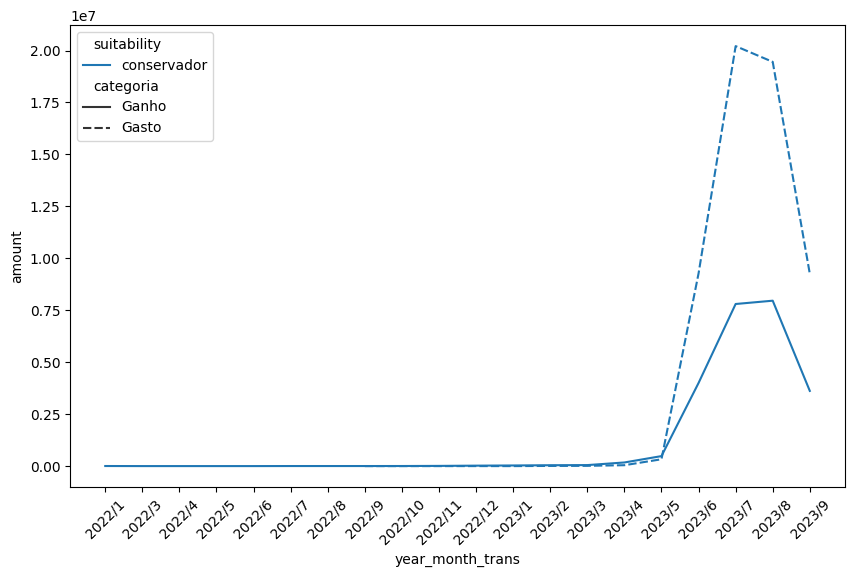

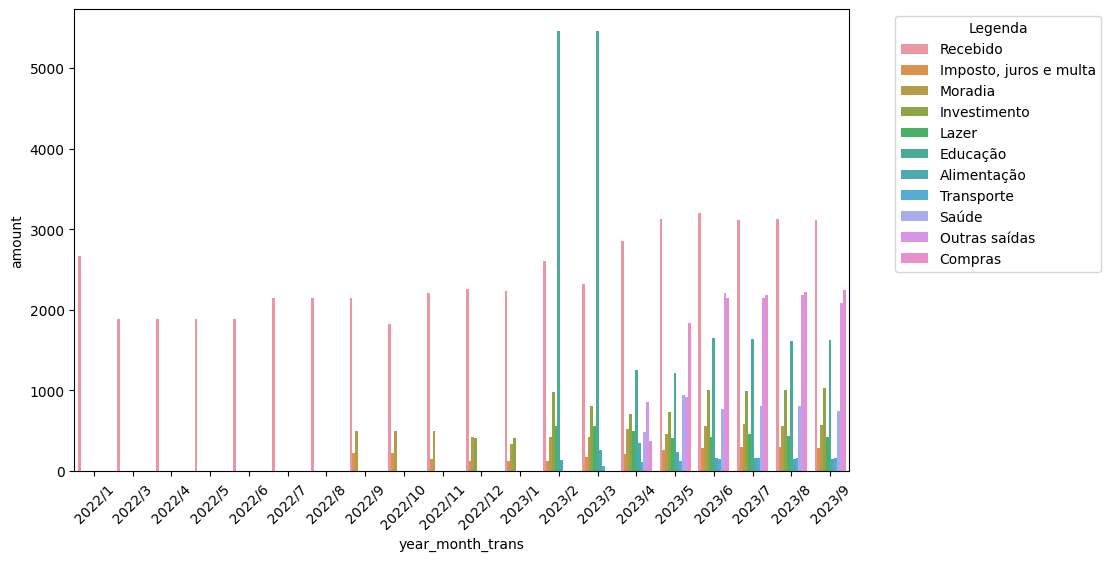

----------------------------------------
MODERADO-AGRESSIVO


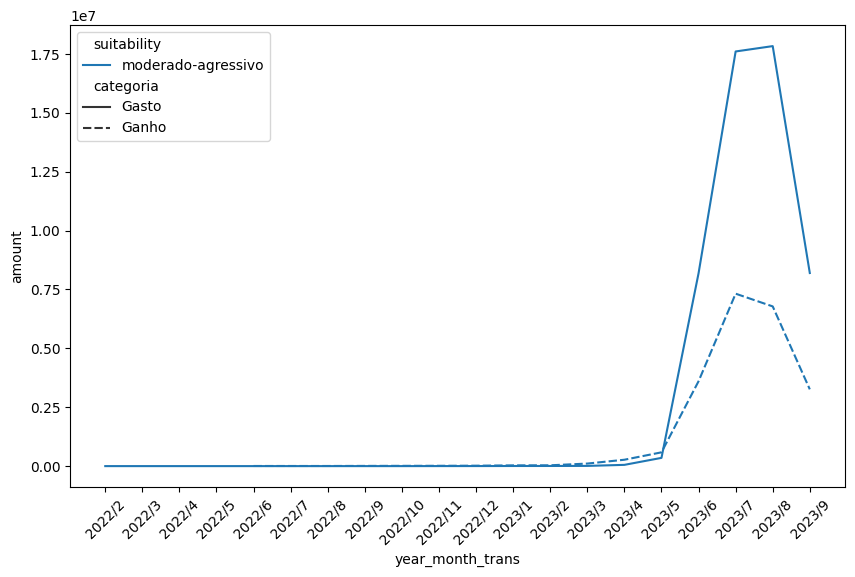

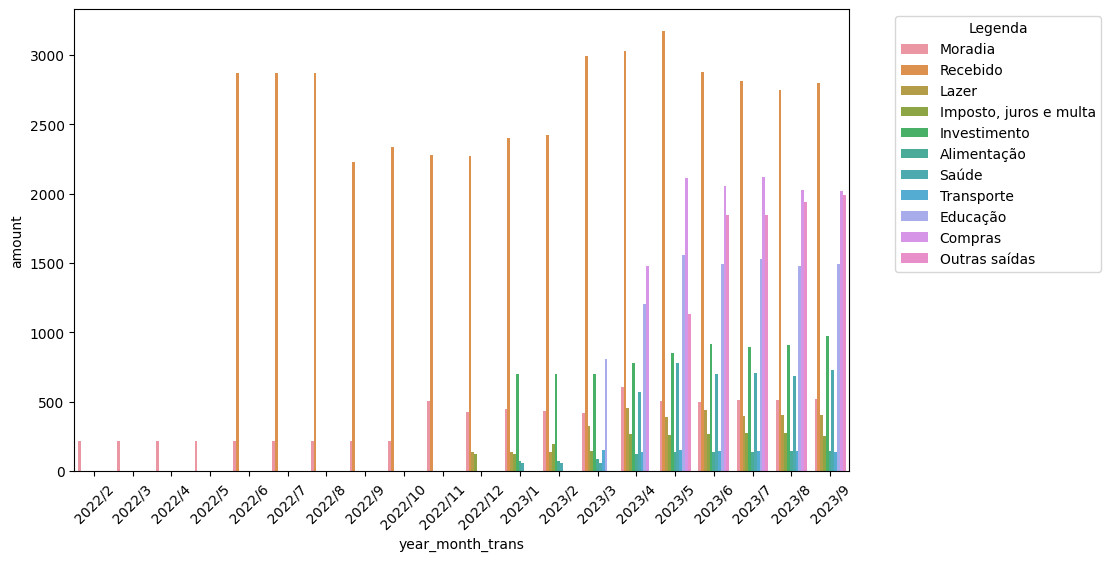

----------------------------------------
MODERADO-CONSERVADOR


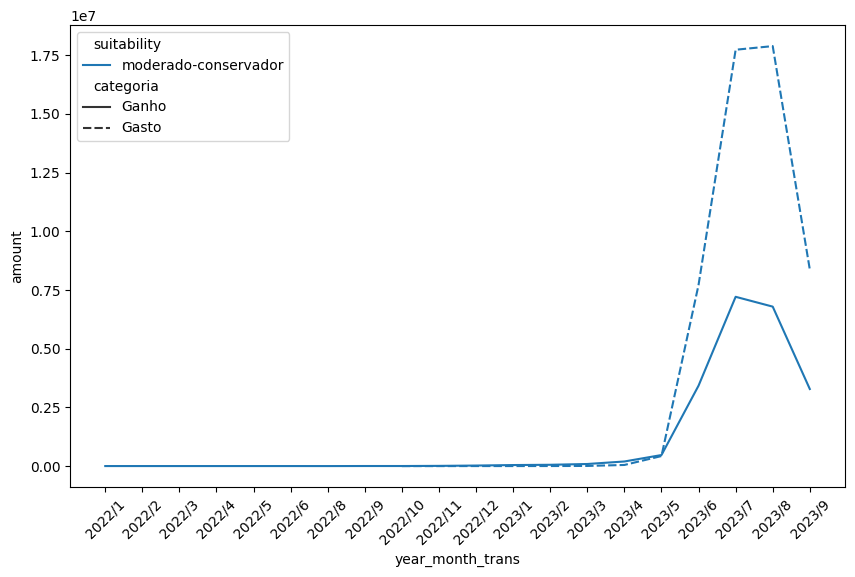

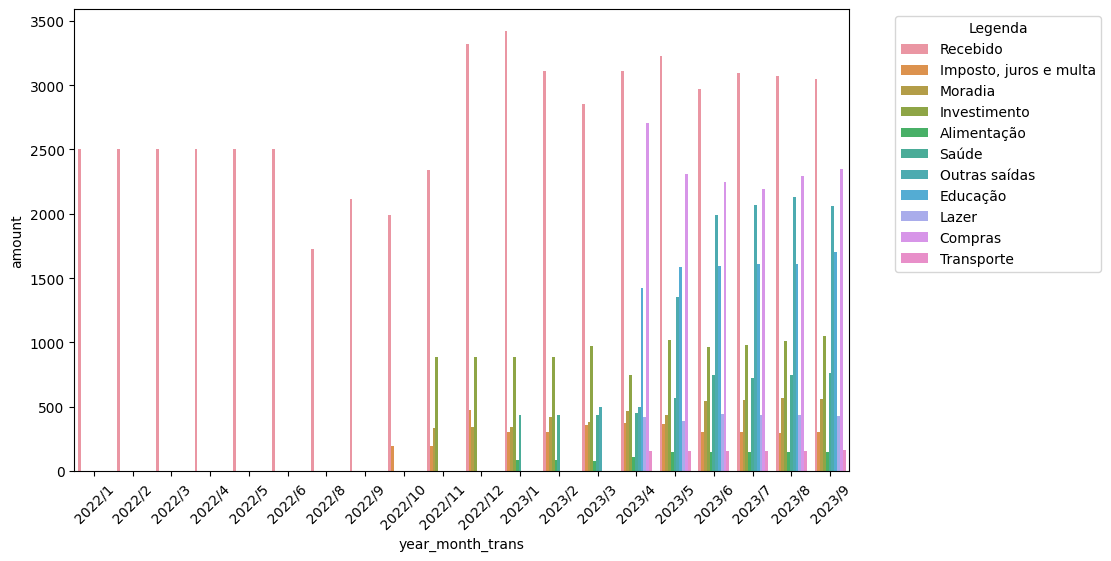

----------------------------------------
MODERADO


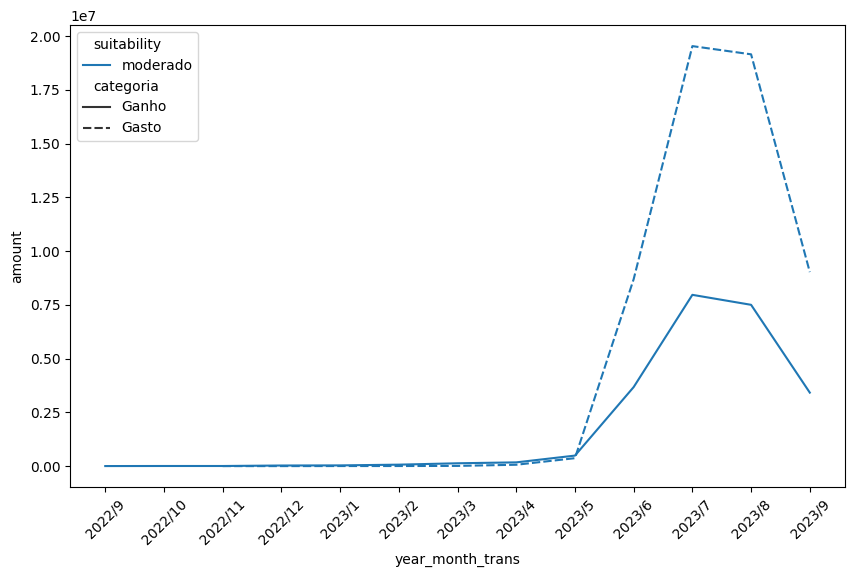

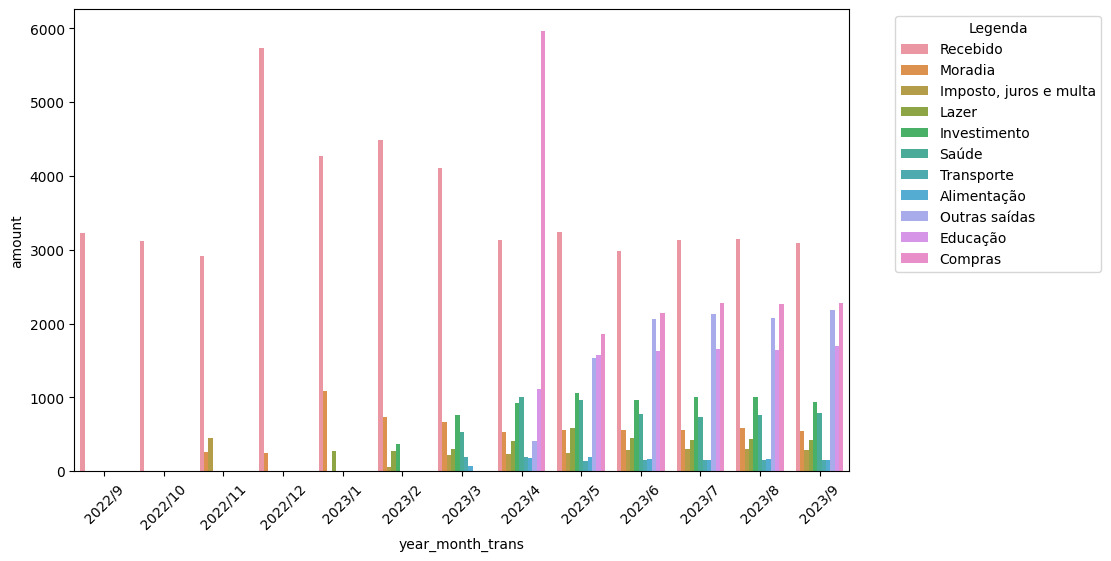

----------------------------------------
NO_SUITABILITY


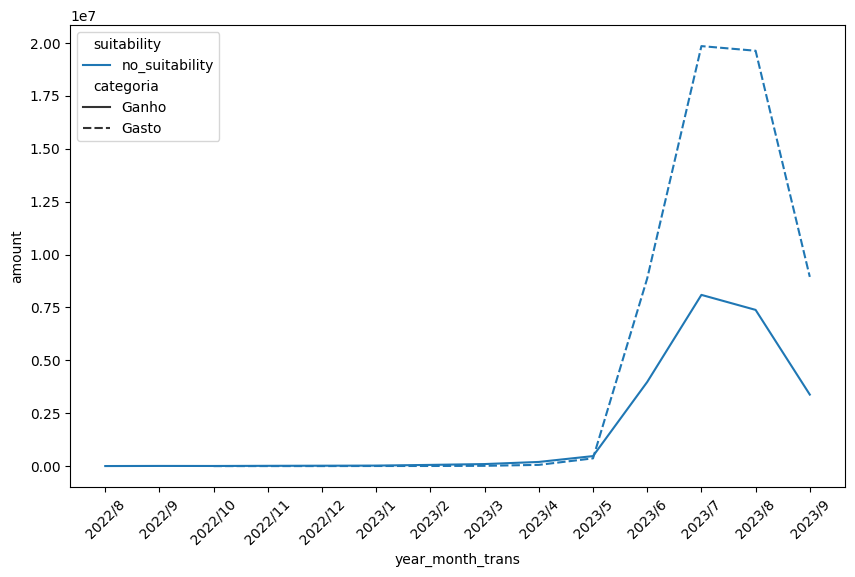

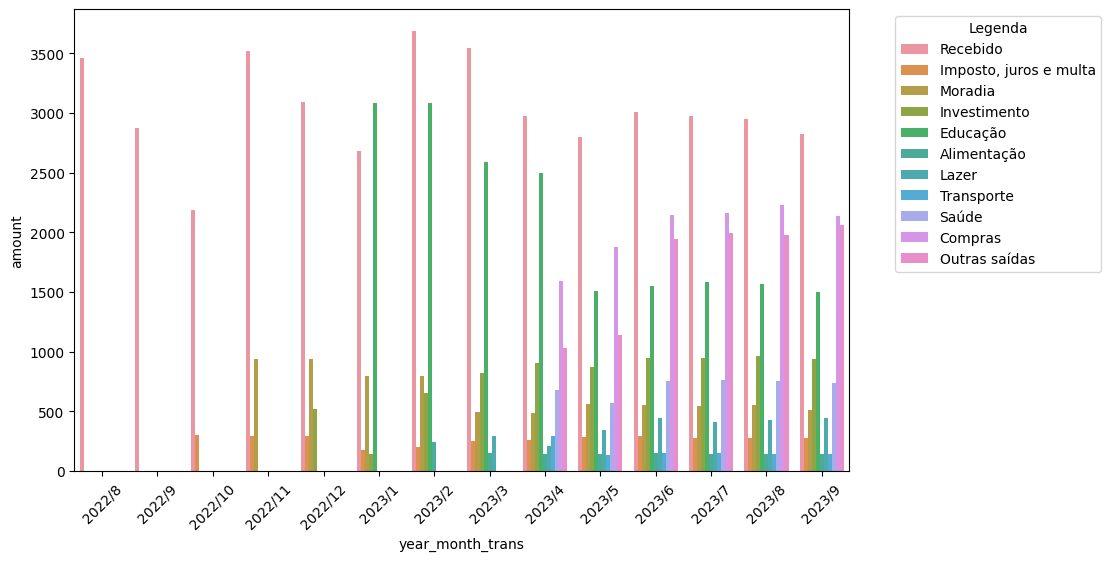

----------------------------------------
AGRESSIVO


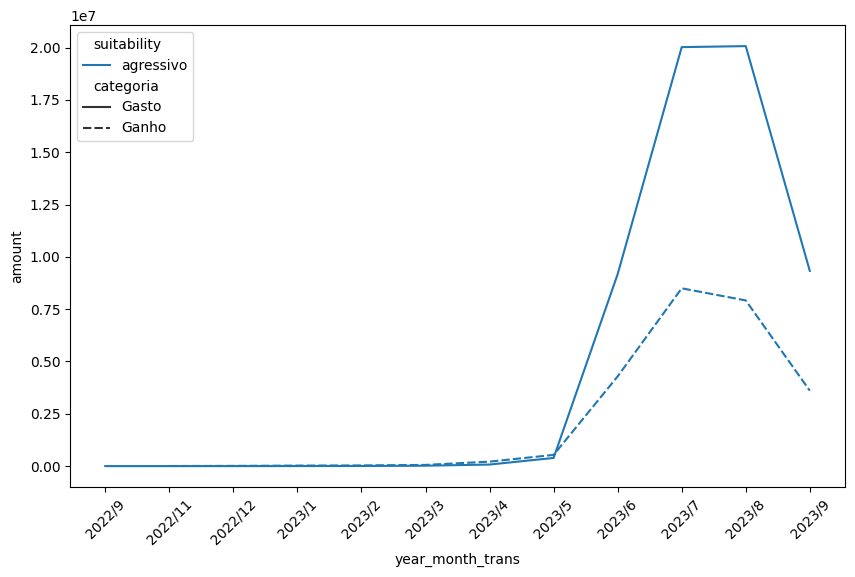

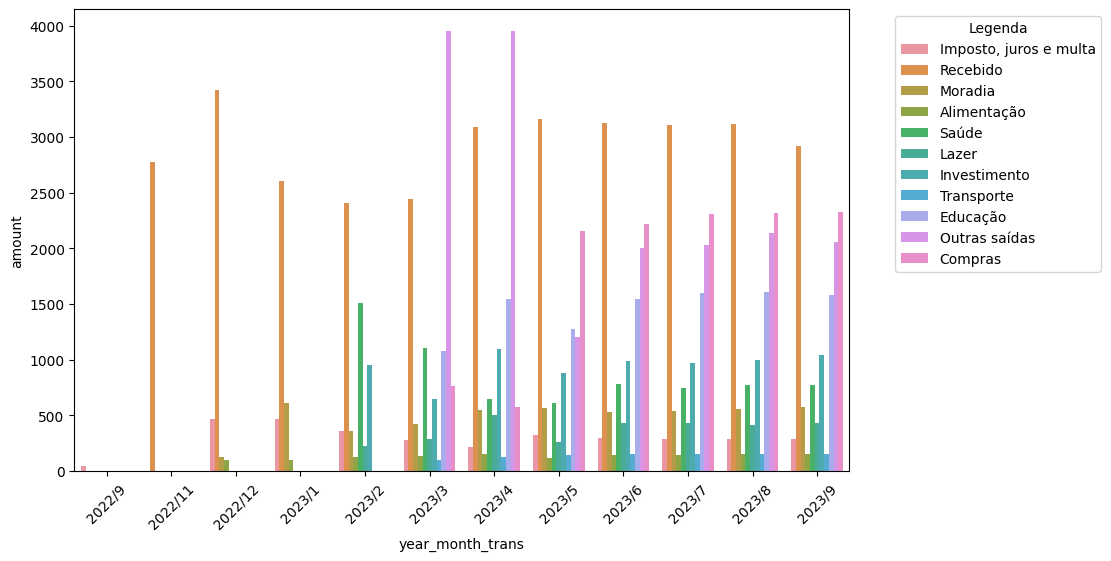

----------------------------------------


In [86]:
for i in df_bivariado.suitability.unique():
    gasto_recebido_suit(df_bivariado, i)

In [87]:
# Criando uma função para automatizar o grafico de um cliente específico
def gasto_recebido(df, id_person): 
    # Filtrando dados para excluir 'no_suitability'
    df_filtered = df[df['suitability'] != 'no_suitability']
    df_filtered = df[df['category'] != 'no_category']
    
    df_filtered = df_filtered[df_filtered.id_person == id_person]
    
    # Criando DataFrames separados para "Gasto" e "Ganho"
    df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
    df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

    # Agrupando e somar os valores
    df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
    df_recebidos = df_recebidos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

    # Adicionando uma coluna 'categoria' para indicar se é gasto ou recebido
    df_gastos['categoria'] = 'Gasto'
    df_recebidos['categoria'] = 'Ganho'

    # Combinar os DataFrames de gastos e recebidos
    df_combined = pd.concat([df_gastos, df_recebidos])

    # Criar um gráfico de linhas dividido por "Gasto" e "Ganho"
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                 hue='suitability', style='categoria')
    plt.xticks(rotation=45)
    plt.show()

    # Criar um gráfico de linhas dividido por "Gasto" e "Ganho"
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_filtered.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                     hue='category', errorbar=None)
    plt.xticks(rotation=45)
    plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

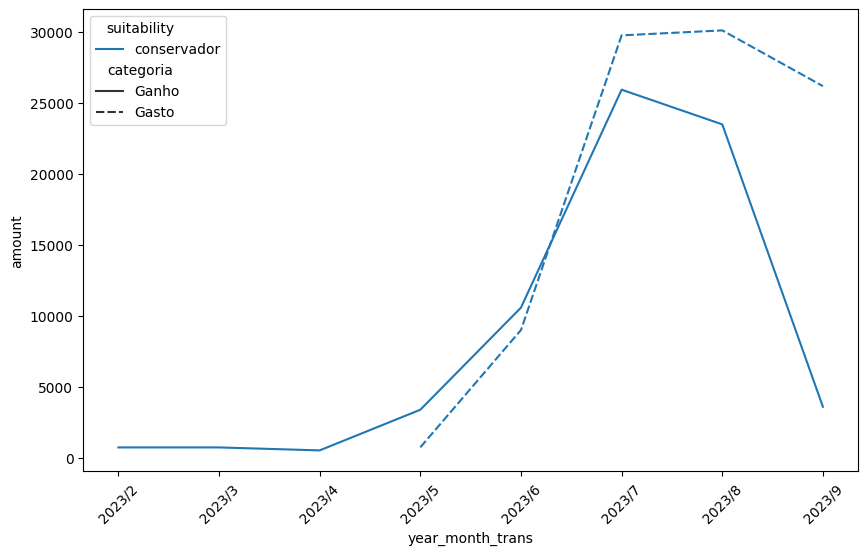

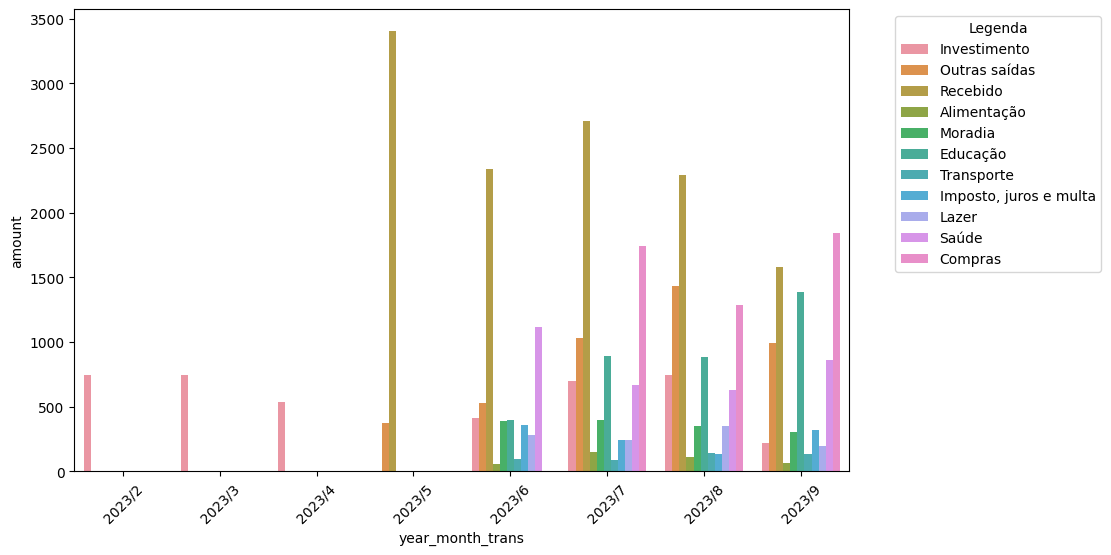

In [88]:
#Exemplo:
gasto_recebido(df_bivariado, '644f5d18-5bfa-45f9-8aa7-401c05b3b9f2')

### Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.

In [89]:
# Pode ser uma transação específica ou de modo geral para o dataframe
def transaction_periodicity(df, transaction_to_check=None):
    df['date_trans'] = pd.to_datetime(df['date_trans'])
    df['month_trans'] = df['date_trans'].dt.month
    df['year_trans'] = df['date_trans'].dt.year
    df['year_month_trans'] = df['year_trans'].astype(str) + "/" + df['month_trans'].astype(str)

    grouped = df.groupby(['category', 'account_id', 'year_month_trans'])['amount'].mean().reset_index()
    grouped_count = df.groupby(['category', 'account_id', 'amount'])['year_month_trans'].count().reset_index()

    df = df.merge(grouped, on=['category', 'account_id', 'year_month_trans'], suffixes=('', '_mean'))
    df = df.merge(grouped_count, on=['category', 'account_id', 'amount'], suffixes=('', '_count'))

    df['fixed_expense'] = False
    df.loc[(df['amount'] == df['amount_mean']) & (df['year_month_trans_count'] != 1), 'fixed_expense'] = True
    
    if transaction_to_check is not None:
        if transaction_to_check is not None:
            transaction = df[df['id'] == transaction_to_check]
            if not transaction.empty:
                category = transaction['category'].values[0]
                expense_type = 'Fixa' if transaction['fixed_expense'].values[0] else 'Variável'
                return f"A transação {transaction_to_check}, da categoria {category}, é {expense_type}"
            else:
                return "Transação não encontrada."
    return df


In [90]:
# Exemplo:
transaction_periodicity(transactions,"25d75edf-c379-41af-ac44-794346c7ba46")

'A transação 25d75edf-c379-41af-ac44-794346c7ba46, da categoria Outras saídas, é Fixa'

In [91]:
df = transactions[transactions.amount < 0]
df_period = transaction_periodicity(transactions)

In [92]:
df_period.fixed_expense.value_counts()

False    387711
True      12399
Name: fixed_expense, dtype: int64

In [93]:
df_period.head()

,id,amount,category,account_id,date_trans,year_month_trans,month_trans,year_trans,amount_mean,year_month_trans_count,fixed_expense
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20,2023/7,7,2023,890.29,1,False
1,d8fc8050-f201-4037-bde3-18d17d1d38b6,1553.85,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-02,2023/7,7,2023,890.29,1,False
2,53073dc0-8aab-4297-8129-83402df68c22,618.31,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-15,2023/7,7,2023,890.29,1,False
3,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23,2023/7,7,2023,265.00,1,False
4,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26,2023/6,6,2023,18.95,1,False


### Unsupervised Clustering usando K-Means para segmentar os clientes em diferentes perfis de gastos.

Para a clusterização dos clientes usarei a soma dos gastos do ano de 2023 pois possuem os dados estão mais completos e são mais recentes

In [94]:
accounts['date_acc'] = pd.to_datetime(accounts.date_acc)
accounts_2023 = accounts[accounts.date_acc >= pd.to_datetime(2023-1-1)]
accounts_2023['year_acc'] = accounts_2023['date_acc'].dt.year

transactions_2023 = transactions[transactions.year_trans >= 2023]
transactions_period_2023 = df_period[df_period.year_trans >= 2023]

In [95]:
accounts_2023.columns

Index(['id', 'type', 'subtype', 'balance', 'name', 'person_id', 'date_acc',
       'year_month_acc', 'year_acc'],
      dtype='object')

In [96]:
accounts_2023.shape

(7569, 9)

In [97]:
accounts_2023 = accounts_2023.groupby(['person_id', 'id','name', 'year_acc'])['balance'].sum().reset_index()

In [98]:
accounts_2023

,person_id,id,name,year_acc,balance
0,000be23a-894b-4eca-aa31-5373556f8204,026fa532-8365-4cd9-82f3-d111de954005,Cartão de Crédito,2023,2692.21
1,000be23a-894b-4eca-aa31-5373556f8204,60a08029-aae2-4b0f-ba97-913eb52c4688,Conta Remunerada,2023,9993.24
2,000be23a-894b-4eca-aa31-5373556f8204,cd8b83be-d795-4e24-817e-feb030d8982e,Cartão de Crédito,2023,9112.60
3,000be23a-894b-4eca-aa31-5373556f8204,e1368c04-175a-40f6-9d31-956e7e00ff17,Conta Remunerada,2023,1144.36
4,000be23a-894b-4eca-aa31-5373556f8204,eb0cc800-2cb0-46ee-966e-bc1bf76d65b1,Cartão de Crédito,2023,6187.12
...,...,...,...,...,...
7564,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,ec6977f0-9978-4502-9dec-6e2e736d077b,Conta Corrente,2023,3037.63
7565,ffd751aa-327e-457d-bba1-8605ea1e3a6b,3e968d0a-4c37-4c89-a769-d727cb019ab3,Cartão de Crédito,2023,1773.83
7566,ffd751aa-327e-457d-bba1-8605ea1e3a6b,cb816c1e-2873-4891-9635-8505479aee35,Conta Remunerada,2023,1707.00
7567,ffe36cb3-c406-46dd-931e-0b38143a1b7c,a756a1f0-3eec-4597-8977-ac2549781f4c,Conta Corrente,2023,8553.13


In [99]:
# Reestruturando a tabela para criar uma coluna para cada tipo de 'balance' e seus valores estejam em cada uma dessas colunas 
pivot_table_acc = accounts_2023.pivot_table(
    values=['balance'],
    index=['id','person_id'],
    columns=['name'],
    aggfunc='sum',
    fill_value=0
).reset_index()
pivot_table_acc.columns = ['_'.join(map(str, col)) if col[1] != '' else col[0] for col in pivot_table_acc.columns]

In [100]:
pivot_table_acc.head()

,id,person_id,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança
0,0000c62a-c0ba-49df-8a3d-682e34672167,f16cbf47-058f-4dd9-abd7-041c69a034de,0.00,0.00,6739.18,0.0,0.0
1,00042933-5d75-4bc1-98a6-2070dd7ffeeb,51eee0e8-1690-44dd-b825-7b3c405fce9f,0.00,0.00,7817.76,0.0,0.0
2,00073e2a-29fd-491e-930c-62c852a87372,adee2135-bc42-4c4f-a8ec-23c0218eb8be,0.00,7216.24,0.00,0.0,0.0
3,001216e2-6e26-4bfa-85b4-91ad461821ad,6745a751-fd32-4a0d-9bed-7f9d23534a3a,8289.84,0.00,0.00,0.0,0.0
4,0014100f-e601-4ce6-bcba-bc5fd6115fa8,3fda7b1a-020f-4a86-8cd0-a7da818875ce,0.00,5779.39,0.00,0.0,0.0


In [101]:
transactions_period_2023.columns

Index(['id', 'amount', 'category', 'account_id', 'date_trans',
       'year_month_trans', 'month_trans', 'year_trans', 'amount_mean',
       'year_month_trans_count', 'fixed_expense'],
      dtype='object')

In [102]:
# Reestruturando a tabela para criar uma coluna para cada categoria de gasto e seus valores estejam em cada uma dessas colunas 
pivot_table_trans = transactions_period_2023.pivot_table(
    values=['amount', 'fixed_expense'],
    index=['account_id', 'year_trans'],
    columns=['category'],
    aggfunc={'amount':'sum', 'fixed_expense': 'count'},
    fill_value=0
).reset_index()
pivot_table_trans.columns = ['_'.join(map(str, col)) if col[1] != '' else col[0] for col in pivot_table_trans.columns]

In [103]:
pivot_table_trans

,account_id,year_trans,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,...,fixed_expense_Compras,fixed_expense_Educação,"fixed_expense_Imposto, juros e multa",fixed_expense_Investimento,fixed_expense_Lazer,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte
0,0000c62a-c0ba-49df-8a3d-682e34672167,2023,696.69,2869.19,8425.33,1140.54,4313.37,1985.12,2829.60,2886.86,...,3,7,7,7,6,8,3,6,8,4
1,00042933-5d75-4bc1-98a6-2070dd7ffeeb,2023,334.86,5870.29,3913.57,677.14,8196.37,316.19,1128.81,11475.55,...,4,2,4,10,2,3,8,4,3,6
2,00073e2a-29fd-491e-930c-62c852a87372,2023,364.23,0.00,765.66,1503.21,2950.40,706.81,1436.28,8248.79,...,0,1,5,3,4,4,10,2,5,2
3,001216e2-6e26-4bfa-85b4-91ad461821ad,2023,537.22,13318.44,10306.56,2493.95,7504.20,3400.92,1434.85,29411.91,...,8,8,9,9,8,5,17,10,7,9
4,0014100f-e601-4ce6-bcba-bc5fd6115fa8,2023,1203.47,10439.42,4828.11,737.13,3346.97,2882.24,2542.13,28628.94,...,10,3,5,7,9,5,20,8,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,ffaf58f1-0f3d-41a6-b3fd-6c2c96e0e520,2023,624.74,14388.97,1548.93,2598.42,0.00,0.00,0.00,29353.61,...,1,1,2,0,0,0,4,0,5,3
7565,ffc7b382-2a53-41ae-86ce-159e5d64d8bf,2023,309.42,2374.46,775.48,1179.17,1167.63,1163.02,2407.20,7420.17,...,1,1,4,3,4,6,9,3,5,0
7566,ffd0f15d-f5f0-4474-ab60-912da0a01373,2023,245.06,1070.56,1313.91,149.71,532.40,2540.33,2297.52,2851.67,...,1,1,1,1,5,6,3,1,4,0
7567,ffd4bcbd-62be-45d6-990a-9d983c29013c,2023,838.19,11956.01,7267.71,333.19,2524.26,1083.64,1797.97,19166.60,...,7,6,3,5,2,5,15,6,5,15


In [104]:
count_fixed_expense = transactions_period_2023.groupby(['account_id'])['fixed_expense'].sum().reset_index()
pivot_table_trans = pivot_table_trans.merge(count_fixed_expense, on='account_id')

In [105]:
pivot_table_trans_sum = pivot_table_trans.groupby(['account_id','year_trans']).sum().reset_index()

In [106]:
# Juntando as tabelas
merged_accounts_pivot = pd.merge(person_merge, pivot_table_acc, left_on="id", right_on="person_id", how="left", suffixes=("_person", "_acc"))
merged_data_total_pivot = pd.merge(merged_accounts_pivot, pivot_table_trans_sum, left_on="id_acc", right_on="account_id", how="left", suffixes=("_acc", "_trans"))

In [107]:
merged_data_total_pivot.head()

,id_person,suitability,id_acc,person_id,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,account_id,...,fixed_expense_Educação,"fixed_expense_Imposto, juros e multa",fixed_expense_Investimento,fixed_expense_Lazer,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,3826.72,0.00,0.00,0.0,0.0,1968bd13-dd25-4f88-bccc-5cff92d6811b,...,10,5,6,1,5,4,6,5,6,1
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,6c2a44fe-2ba7-4626-aaff-f244a0647eae,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,5740.29,0.00,0.00,0.0,0.0,6c2a44fe-2ba7-4626-aaff-f244a0647eae,...,1,2,2,3,2,4,3,0,2,2
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,978f92cf-8d5b-437a-a046-cdaa9105624c,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,0.00,6311.67,0.00,0.0,0.0,978f92cf-8d5b-437a-a046-cdaa9105624c,...,8,6,14,7,9,10,9,4,5,6
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,abb359a2-3802-48e7-976b-8671e1de0884,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,0.00,0.00,5136.49,0.0,0.0,abb359a2-3802-48e7-976b-8671e1de0884,...,5,3,6,9,3,7,3,3,4,0
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,dcd96f70-8b16-42b0-a944-afec5d8305ce,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,0.00,7482.25,0.00,0.0,0.0,dcd96f70-8b16-42b0-a944-afec5d8305ce,...,0,0,0,0,1,1,0,0,1,0


In [108]:
merged_data_total_pivot.columns

Index(['id_person', 'suitability', 'id_acc', 'person_id', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'account_id',
       'year_trans', 'amount_Alimentação', 'amount_Compras', 'amount_Educação',
       'amount_Imposto, juros e multa', 'amount_Investimento', 'amount_Lazer',
       'amount_Moradia', 'amount_Outras saídas', 'amount_Recebido',
       'amount_Saúde', 'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense'],
      dtype='object')

In [109]:
merged_data_total_pivot_sum_account = merged_data_total_pivot.groupby(['id_person',"suitability", 'year_trans']).sum().reset_index()

In [110]:
merged_data_total_pivot_sum_account.head()

,id_person,suitability,year_trans,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,...,fixed_expense_Educação,"fixed_expense_Imposto, juros e multa",fixed_expense_Investimento,fixed_expense_Lazer,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,2023,0.00,17991.93,0.00,11137.6,0.00,2605.89,84880.85,...,13,16,22,17,17,35,25,13,21,6
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,2023,5365.67,8417.80,0.00,1740.3,0.00,1609.13,38596.47,...,20,15,16,10,24,45,25,21,13,4
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,2023,0.00,38617.74,16158.72,0.0,11994.51,3779.11,173636.11,...,13,8,17,6,11,18,5,13,6,2
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,2023,0.00,8966.13,0.00,0.0,0.00,166.48,11233.45,...,3,6,5,5,7,12,9,6,6,1
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,agressivo,2023,0.00,5198.37,0.00,0.0,0.00,0.00,2012.48,...,4,3,0,3,4,3,6,4,0,0


In [111]:
merged_data_total_pivot_sum_account.columns

Index(['id_person', 'suitability', 'year_trans', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense'],
      dtype='object')

In [112]:
# Criando as colunas de soma das variáveis de gasto, balance e quantidades de compras
merged_data_total_pivot_sum_account['gastos_totais'] =  merged_data_total_pivot_sum_account[['amount_Alimentação', 'amount_Compras', 'amount_Educação',
                                                        'amount_Imposto, juros e multa', 'amount_Lazer', 'amount_Moradia',
                                                        'amount_Outras saídas', 'amount_Saúde', 'amount_Transporte']].sum(axis=1)

merged_data_total_pivot_sum_account['balance_totais'] =  merged_data_total_pivot_sum_account[['balance_Caixinha', 'balance_Cartão de Crédito', 'balance_Conta Corrente',
                                                         'balance_Conta Remunerada', 'balance_Poupança']].sum(axis=1)

merged_data_total_pivot_sum_account['qtd_gastos_totais'] =  merged_data_total_pivot_sum_account[['fixed_expense_Alimentação', 'fixed_expense_Compras',
                                                            'fixed_expense_Educação', 'fixed_expense_Imposto, juros e multa', 'fixed_expense_Lazer', 
                                                            'fixed_expense_Moradia', 'fixed_expense_Outras saídas','fixed_expense_Saúde', 
                                                            'fixed_expense_Transporte']].sum(axis=1)

merged_data_total_pivot_sum_account['qtd_gastos_variaveis'] = merged_data_total_pivot_sum_account['qtd_gastos_totais'] - merged_data_total_pivot_sum_account['fixed_expense']

In [113]:
# Criando um df para utilizar posteriormente para prever o suitability
data_no_suitability = merged_data_total_pivot_sum_account[merged_data_total_pivot_sum_account.suitability == "no_suitability"]

In [114]:
data_no_suitability.head()

,id_person,suitability,year_trans,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,...,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense,gastos_totais,balance_totais,qtd_gastos_totais,qtd_gastos_variaveis
6,009c965d-d253-470d-9856-b7a5fcd956db,no_suitability,2023,0.00,0.00,12208.86,0.00,8407.82,1861.52,18163.75,...,24,43,18,17,15,2,146698.51,20616.68,184,182
10,00e2ff4c-21ca-42d1-8e54-1ab99de54946,no_suitability,2023,0.00,0.00,3192.72,0.00,0.00,660.72,3455.97,...,10,7,3,7,4,2,29611.64,3192.72,54,52
17,01c0abcc-41a0-4e0a-ab8b-748affa75128,no_suitability,2023,8230.75,8745.78,5043.64,9938.98,0.00,3449.60,52673.49,...,30,47,22,32,20,8,182866.49,31959.15,270,262
23,0252a7c0-8d91-4fa5-ad74-2fff3134b22b,no_suitability,2023,0.00,0.00,0.00,243.69,13737.12,1226.57,22229.01,...,11,20,14,14,10,8,92000.38,13980.81,130,122
26,02ae818d-6310-4f7e-8d71-a59151cbe569,no_suitability,2023,5013.50,4307.87,674.12,2617.91,0.00,2731.30,46080.12,...,28,46,37,18,18,6,183763.24,12613.40,235,229


In [115]:
# Separando os dados que não possuem o perfil definido
data_total = merged_data_total_pivot_sum_account[merged_data_total_pivot_sum_account.suitability != "no_suitability"]

In [116]:
data_total.head()

,id_person,suitability,year_trans,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,...,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense,gastos_totais,balance_totais,qtd_gastos_totais,qtd_gastos_variaveis
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,2023,0.00,17991.93,0.00,11137.6,0.00,2605.89,84880.85,...,17,35,25,13,21,6,272522.15,29129.53,167,161
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,2023,5365.67,8417.80,0.00,1740.3,0.00,1609.13,38596.47,...,24,45,25,21,13,4,157476.53,15523.77,189,185
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,2023,0.00,38617.74,16158.72,0.0,11994.51,3779.11,173636.11,...,11,18,5,13,6,2,550251.13,66770.97,97,95
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,2023,0.00,8966.13,0.00,0.0,0.00,166.48,11233.45,...,7,12,9,6,6,1,36841.44,8966.13,54,53
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,agressivo,2023,0.00,5198.37,0.00,0.0,0.00,0.00,2012.48,...,4,3,6,4,0,0,16679.50,5198.37,22,22


array([[<AxesSubplot: title={'center': 'year_trans'}>,
        <AxesSubplot: title={'center': 'balance_Caixinha'}>,
        <AxesSubplot: title={'center': 'balance_Cartão de Crédito'}>,
        <AxesSubplot: title={'center': 'balance_Conta Corrente'}>,
        <AxesSubplot: title={'center': 'balance_Conta Remunerada'}>,
        <AxesSubplot: title={'center': 'balance_Poupança'}>],
       [<AxesSubplot: title={'center': 'amount_Alimentação'}>,
        <AxesSubplot: title={'center': 'amount_Compras'}>,
        <AxesSubplot: title={'center': 'amount_Educação'}>,
        <AxesSubplot: title={'center': 'amount_Imposto, juros e multa'}>,
        <AxesSubplot: title={'center': 'amount_Investimento'}>,
        <AxesSubplot: title={'center': 'amount_Lazer'}>],
       [<AxesSubplot: title={'center': 'amount_Moradia'}>,
        <AxesSubplot: title={'center': 'amount_Outras saídas'}>,
        <AxesSubplot: title={'center': 'amount_Recebido'}>,
        <AxesSubplot: title={'center': 'amount_Saúde'}

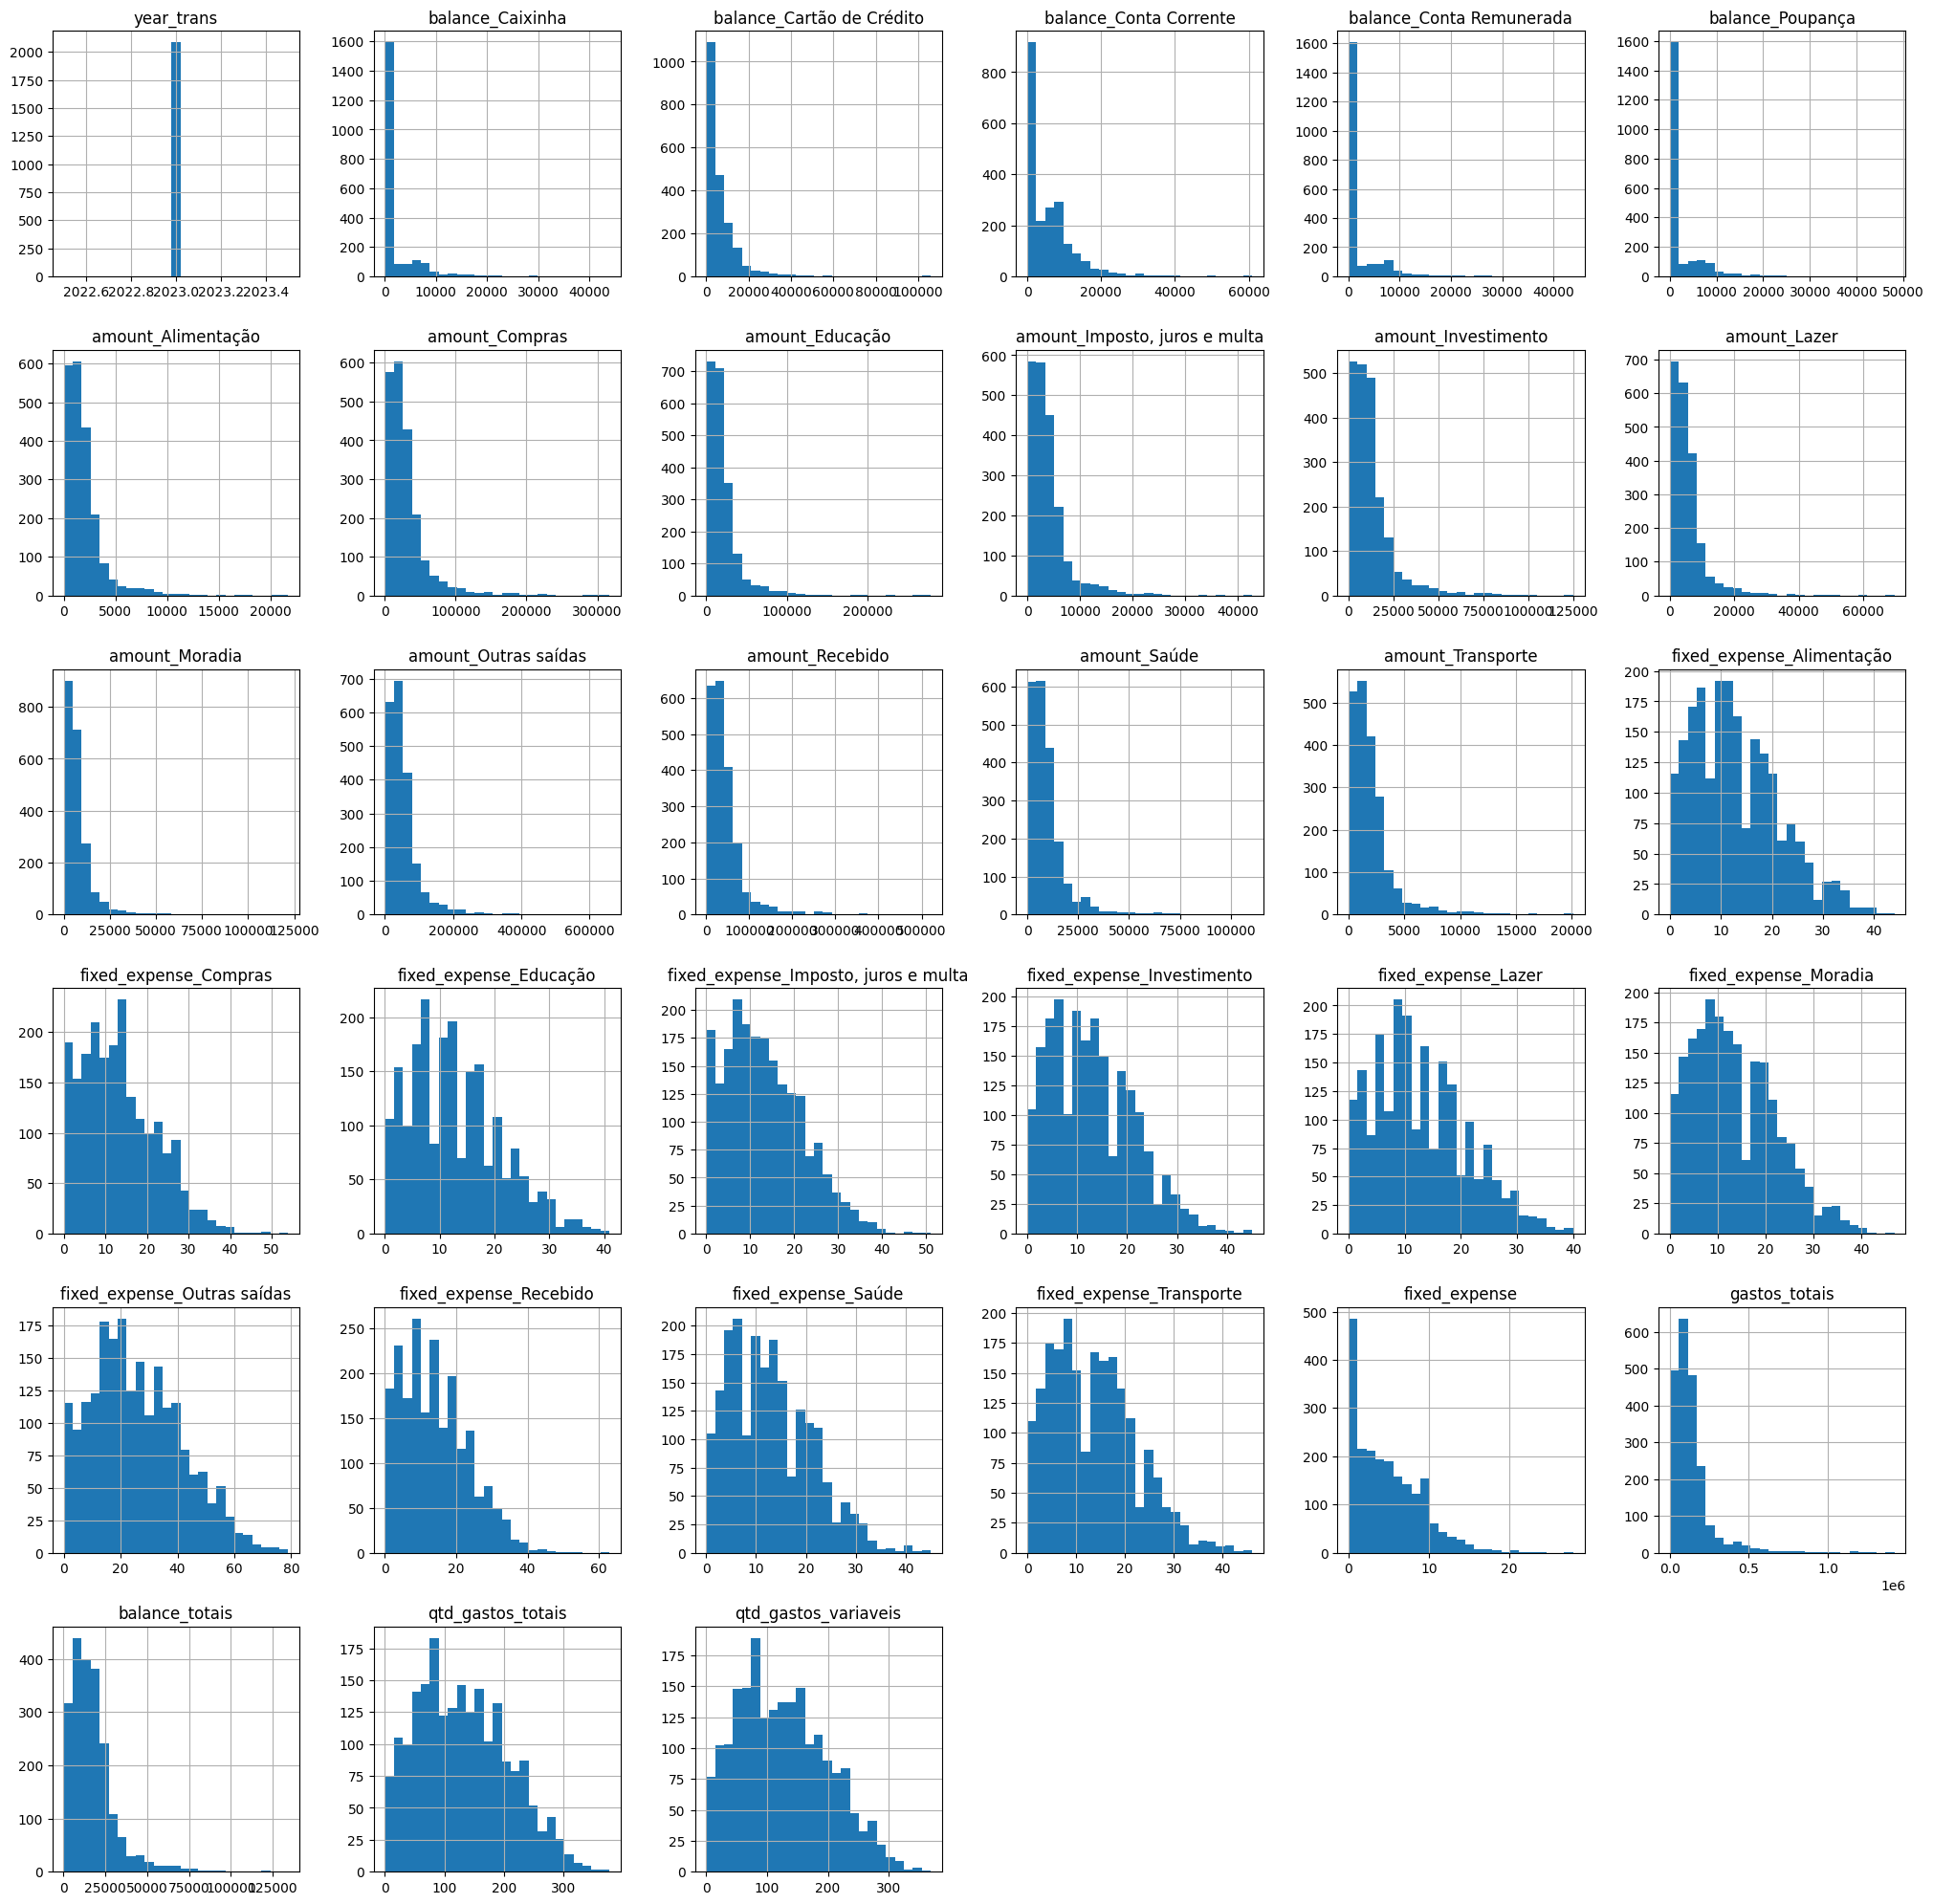

In [117]:
# Separando os dados numéricos e analisando suas distribuições
dados_numericos = data_total.select_dtypes(include=['int64', 'float64'])
dados_numericos.hist(figsize=(25, 25), bins=25)

In [118]:
data_total.columns

Index(['id_person', 'suitability', 'year_trans', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense',
       'gastos_totais', 'balance_totais', 'qtd_gastos_totais',
       'qtd_gastos_variaveis'],
      dtype='object')

In [119]:
# Retirando o dado de ano e verificando sua correlação. Usado correlação de Speraman pois os dados não apresentam distribuição normal
data_total.drop('year_trans', axis=1).corr(numeric_only=True, method='spearman')

,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,...,fixed_expense_Moradia,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense,gastos_totais,balance_totais,qtd_gastos_totais,qtd_gastos_variaveis
balance_Caixinha,1.000000,-0.039698,-0.022574,-0.049622,-0.043631,0.181695,0.193298,0.169745,0.179231,0.188661,...,0.203379,0.212628,0.195175,0.213575,0.208127,0.150688,0.192231,0.239632,0.226434,0.226355
balance_Cartão de Crédito,-0.039698,1.000000,-0.061259,-0.021144,-0.059109,0.373176,0.366342,0.358318,0.367008,0.365226,...,0.333184,0.346271,0.321263,0.329538,0.310772,0.244971,0.395355,0.501518,0.356705,0.355384
balance_Conta Corrente,-0.022574,-0.061259,1.000000,-0.037008,-0.043523,0.352368,0.329481,0.347334,0.330396,0.323523,...,0.314210,0.329182,0.310892,0.303876,0.325074,0.277022,0.363612,0.488841,0.345319,0.342081
balance_Conta Remunerada,-0.049622,-0.021144,-0.037008,1.000000,0.026396,0.189330,0.205640,0.218936,0.223064,0.214872,...,0.209879,0.208846,0.209805,0.198320,0.193934,0.180713,0.220267,0.259977,0.223879,0.222017
balance_Poupança,-0.043631,-0.059109,-0.043523,0.026396,1.000000,0.181526,0.211661,0.203987,0.200381,0.198746,...,0.194077,0.228934,0.204791,0.212076,0.208914,0.151818,0.224086,0.262875,0.232393,0.232773
amount_Alimentação,0.181695,0.373176,0.352368,0.189330,0.181526,1.000000,0.798063,0.801362,0.807863,0.809587,...,0.700754,0.733342,0.698343,0.693197,0.686154,0.526803,0.882094,0.666416,0.776905,0.775874
amount_Compras,0.193298,0.366342,0.329481,0.205640,0.211661,0.798063,1.000000,0.786611,0.795445,0.798341,...,0.693074,0.726503,0.689649,0.693193,0.678627,0.506797,0.922602,0.664920,0.770949,0.770470
amount_Educação,0.169745,0.358318,0.347334,0.218936,0.203987,0.801362,0.786611,1.000000,0.808630,0.793295,...,0.695528,0.723791,0.685633,0.688817,0.693535,0.500513,0.900694,0.668704,0.774644,0.774534
"amount_Imposto, juros e multa",0.179231,0.367008,0.330396,0.223064,0.200381,0.807863,0.795445,0.808630,1.000000,0.805738,...,0.678372,0.706088,0.684763,0.686704,0.671452,0.527422,0.883424,0.666043,0.760036,0.758183
amount_Investimento,0.188661,0.365226,0.323523,0.214872,0.198746,0.809587,0.798341,0.793295,0.805738,1.000000,...,0.687706,0.712920,0.686724,0.677616,0.682542,0.513794,0.872977,0.663339,0.746791,0.745129


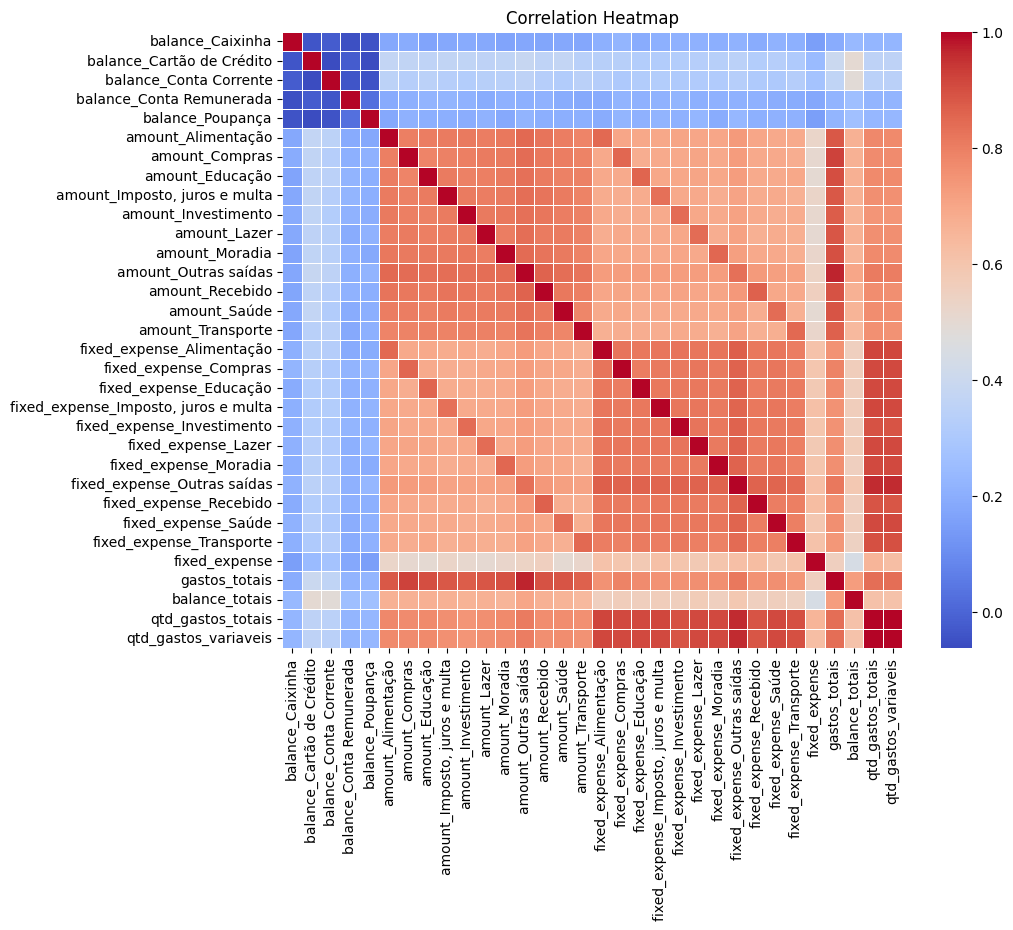

In [120]:
# Criando um heatmap para ver a correlação entre as variáveis. Usado correlação de Speraman pois os dados não apresentam distribuição normal

corr_matrix = data_total.drop('year_trans', axis=1).corr(numeric_only=True, method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [121]:
# Outra forma de ver a correlação e a distribuição das variáveis
# como são muitas variáveis não vale a pena usar essa forma
# sns.pairplot(merged_data_total_pivot, hue='suitability')

In [122]:
data_total.columns

Index(['id_person', 'suitability', 'year_trans', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense',
       'gastos_totais', 'balance_totais', 'qtd_gastos_totais',
       'qtd_gastos_variaveis'],
      dtype='object')

In [123]:
# Selecionando apenas as colunas que serão usadas na clusterização
data = data_total[['amount_Alimentação', 'amount_Compras', 'amount_Educação', 
                        'amount_Imposto, juros e multa', 'amount_Lazer', 'amount_Moradia', 
                        'amount_Outras saídas', 'amount_Saúde', 'amount_Transporte', 
                        'fixed_expense', 'gastos_totais', 'qtd_gastos_variaveis']]

# Normalizando os dados (importante para o K-Means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Escolhendo o K

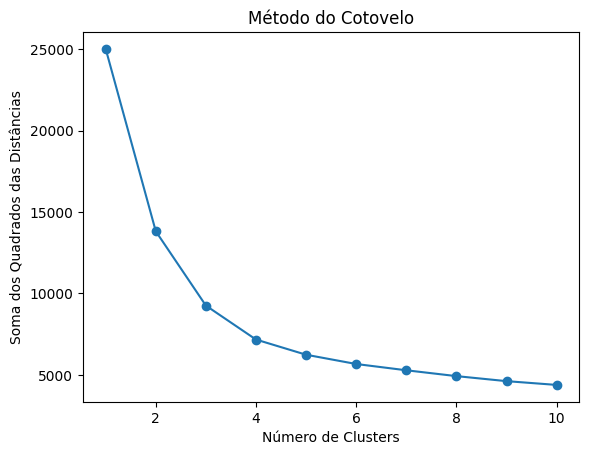

In [124]:
# Pela inércia, no contexto do clustering K-means, refere-se à soma dos quadrados intracluster 
# ou à distância total entre os pontos de dados e seus respectivos centróides de cluster. 

inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.show()

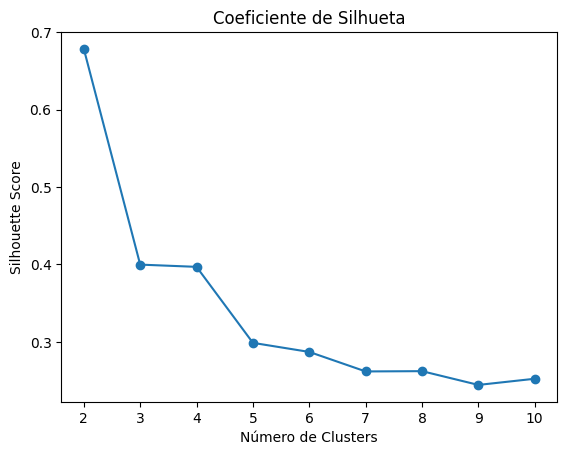

In [125]:
# Ele fornece uma medida de quão bem os objetos estão agrupados, indicando o quão 
# semelhantes eles são aos objetos do mesmo cluster em comparação com objetos de clusters diferentes.
# Utilizar o K que tiver o coeficiente mais alto.

silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

***Aplicar PCA nas Variáveis Relevantes***

Agora que tenho os clusters, podemos escolher quais variáveis são relevantes para o perfil do cliente. 
Após a seleção, aplicarei a PCA para reduzir a dimensionalidade.

In [126]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(data_scaled)

silhouette_score: 0.7164088377435185


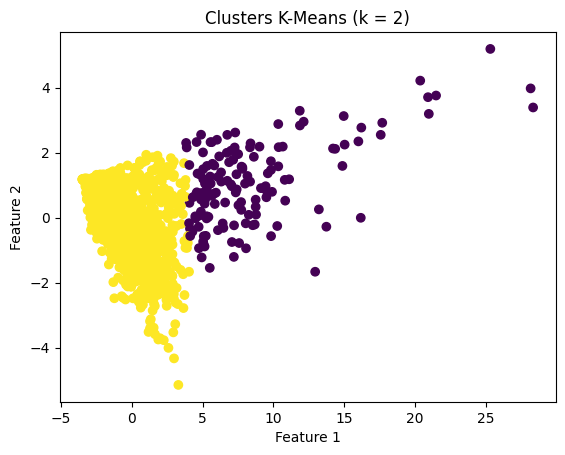

silhouette_score: 0.49828417669147695


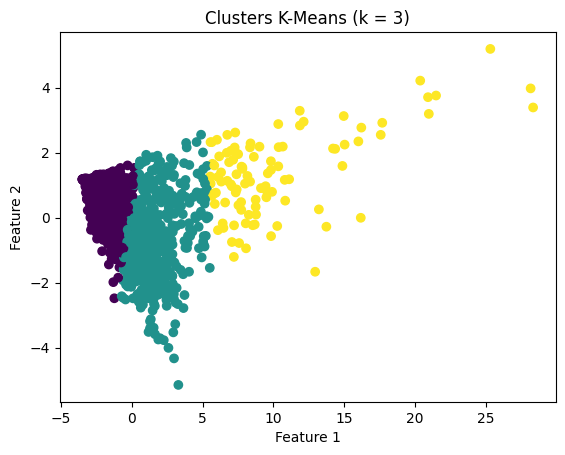

silhouette_score: 0.5058176950636935


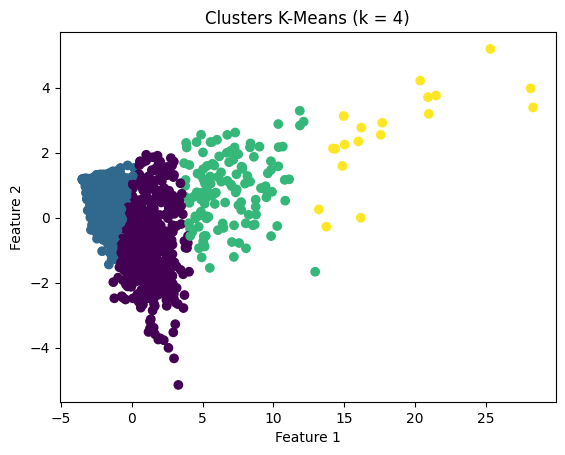

In [127]:
# Escolher o número de clusters
n_clusters = 4

for i in range(2, n_clusters + 1):
    # Aplicando o K-means
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    clusters = kmeans.fit_predict(X_pca)
    
    labels = kmeans.labels_
    print('silhouette_score:', silhouette_score(X_pca, labels, metric='euclidean')) 
    # O Silhouette Score varia de -1 a 1, onde um valor alto indica que o objeto combina bem com o seu próprio agrupamento 

    data_total[f'cluster_{i}'] = clusters
    
    # Mostrando graficamente as divisões
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title(f'Clusters K-Means (k = {i})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.show()

In [128]:
# Salvando o modelo K-means
filename = 'cluster_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [129]:
# load do modelo
Model = pickle.load(open(filename, 'rb'))

### Etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra.
### Respondendo às seguintes perguntas:
###   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
###   - Quais as categorias de compra que mais impactam nos perfis de gasto?
###   - Quais são os perfis centrais (ou típicos) de cada cluster?

In [130]:
por_cluster = data_total.groupby("cluster_2").agg({
    'qtd_gastos_totais':'mean',
    'fixed_expense':'mean',
    'qtd_gastos_variaveis':'mean',
    'amount_Alimentação':'mean', 
    'amount_Compras':'mean',
    'amount_Educação':'mean', 
    'amount_Imposto, juros e multa':'mean', 
    'amount_Lazer':'mean', 
    'amount_Moradia':'mean', 
    'amount_Outras saídas':'mean', 
    'amount_Saúde':'mean', 
    'amount_Transporte':'mean',
    'gastos_totais':'mean'
})

In [131]:
print('Média dos gastos anuais para cada um dos parâmetros testados')
display(por_cluster.T[0].sort_values())
display(por_cluster.T[1].sort_values())

Média dos gastos anuais para cada um dos parâmetros testados


fixed_expense                         7.125000
qtd_gastos_variaveis                189.451389
qtd_gastos_totais                   196.576389
amount_Alimentação                 7397.858333
amount_Transporte                  7853.850139
amount_Imposto, juros e multa     14336.489792
amount_Lazer                      21180.628542
amount_Moradia                    27608.149931
amount_Saúde                      35140.075486
amount_Educação                   78943.564653
amount_Compras                   111836.109444
amount_Outras saídas             196800.151042
gastos_totais                    501096.877361
Name: 0, dtype: float64

fixed_expense                         4.720103
qtd_gastos_variaveis                121.753093
qtd_gastos_totais                   126.473196
amount_Alimentação                 1557.458242
amount_Transporte                  1622.857732
amount_Imposto, juros e multa      3123.349979
amount_Lazer                       4359.814675
amount_Moradia                     5946.196005
amount_Saúde                       7713.669381
amount_Educação                   16160.298773
amount_Compras                    23507.834716
amount_Outras saídas              42624.765448
gastos_totais                    106616.244954
Name: 1, dtype: float64

#### Cluster 0:
- Quantidade de Gastos: Alto
- Natureza dos Gastos: Predominantemente Variado
- Categorias de Compra que mais gastam: Compras e Educação (Embora pareça que houve 'Outras saídas' de gastos, o aumento no valor gasto foi principalmente devido à inclusão dos valores nulos na categoria de despesas, que eu agrupei sob a categoria 'Outras saídas')

#### Cluster 1:
- Quantidade de Gastos: Baixo
- Natureza dos Gastos: Predominantemente Variado
- Categorias de Compra que mais gastam: Compras e Educação (Embora pareça que houve 'Outras saídas' de gastos, o aumento no valor gasto foi principalmente devido à inclusão dos valores nulos na categoria de despesas, que eu agrupei sob a categoria 'Outras saídas')

Podemos ver uma diferença entre os cluster em todos os parâmetros testados


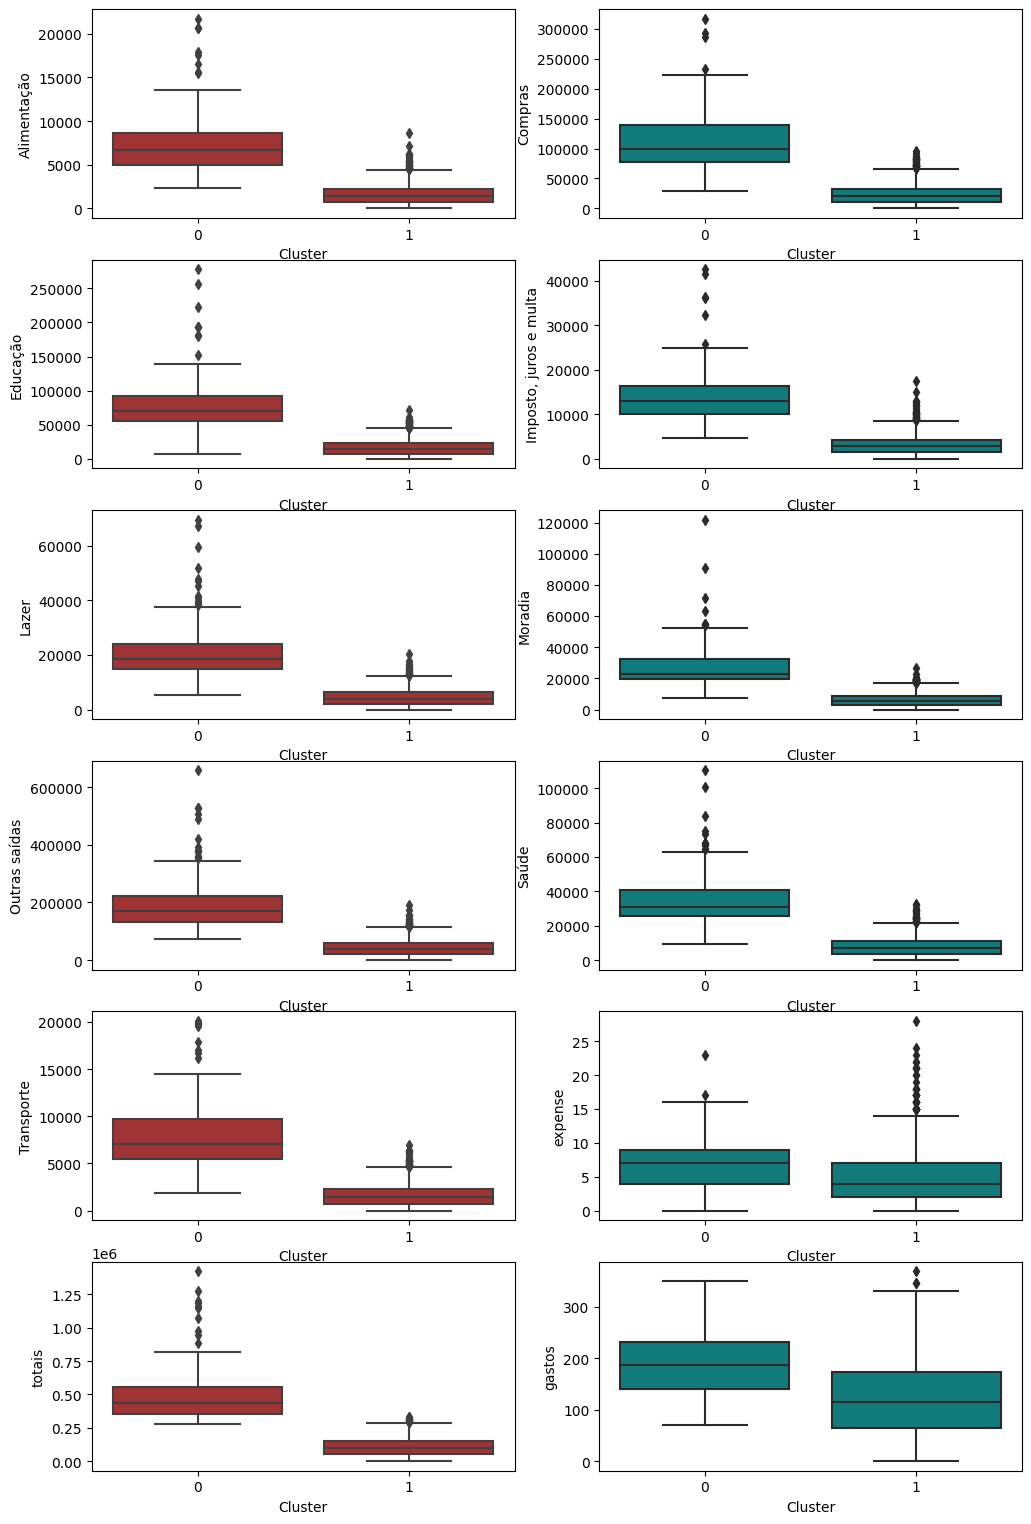

In [132]:
print('Podemos ver uma diferença entre os cluster em todos os parâmetros testados')

fig = plt.figure(figsize=(12, 32))
gs = GridSpec(10, 2)

lista = ['amount_Alimentação', 'amount_Compras', 'amount_Educação', 
        'amount_Imposto, juros e multa', 'amount_Lazer', 'amount_Moradia', 
        'amount_Outras saídas', 'amount_Saúde', 'amount_Transporte', 
        'fixed_expense', 'gastos_totais', 'qtd_gastos_variaveis']

for i in range(1, len(lista),2):
    sns.boxplot(x = 'cluster_2', y=lista[i-1], 
                data=data_total, color='firebrick',
                ax=fig.add_subplot(gs[int((i-1)/2), 0]))
    plt.xlabel('Cluster')
    plt.ylabel(lista[i-1].split("_")[1])

    sns.boxplot(x='cluster_2', y=lista[i], 
                data=data_total, color='darkcyan',
                  ax=fig.add_subplot(gs[int((i-1)/2), 1]))
    plt.xlabel('Cluster')
    plt.ylabel(lista[i].split("_")[1])

plt.show()


Houve uma difereça muito grande entre os clusters em relação a cada um dos parâmetros


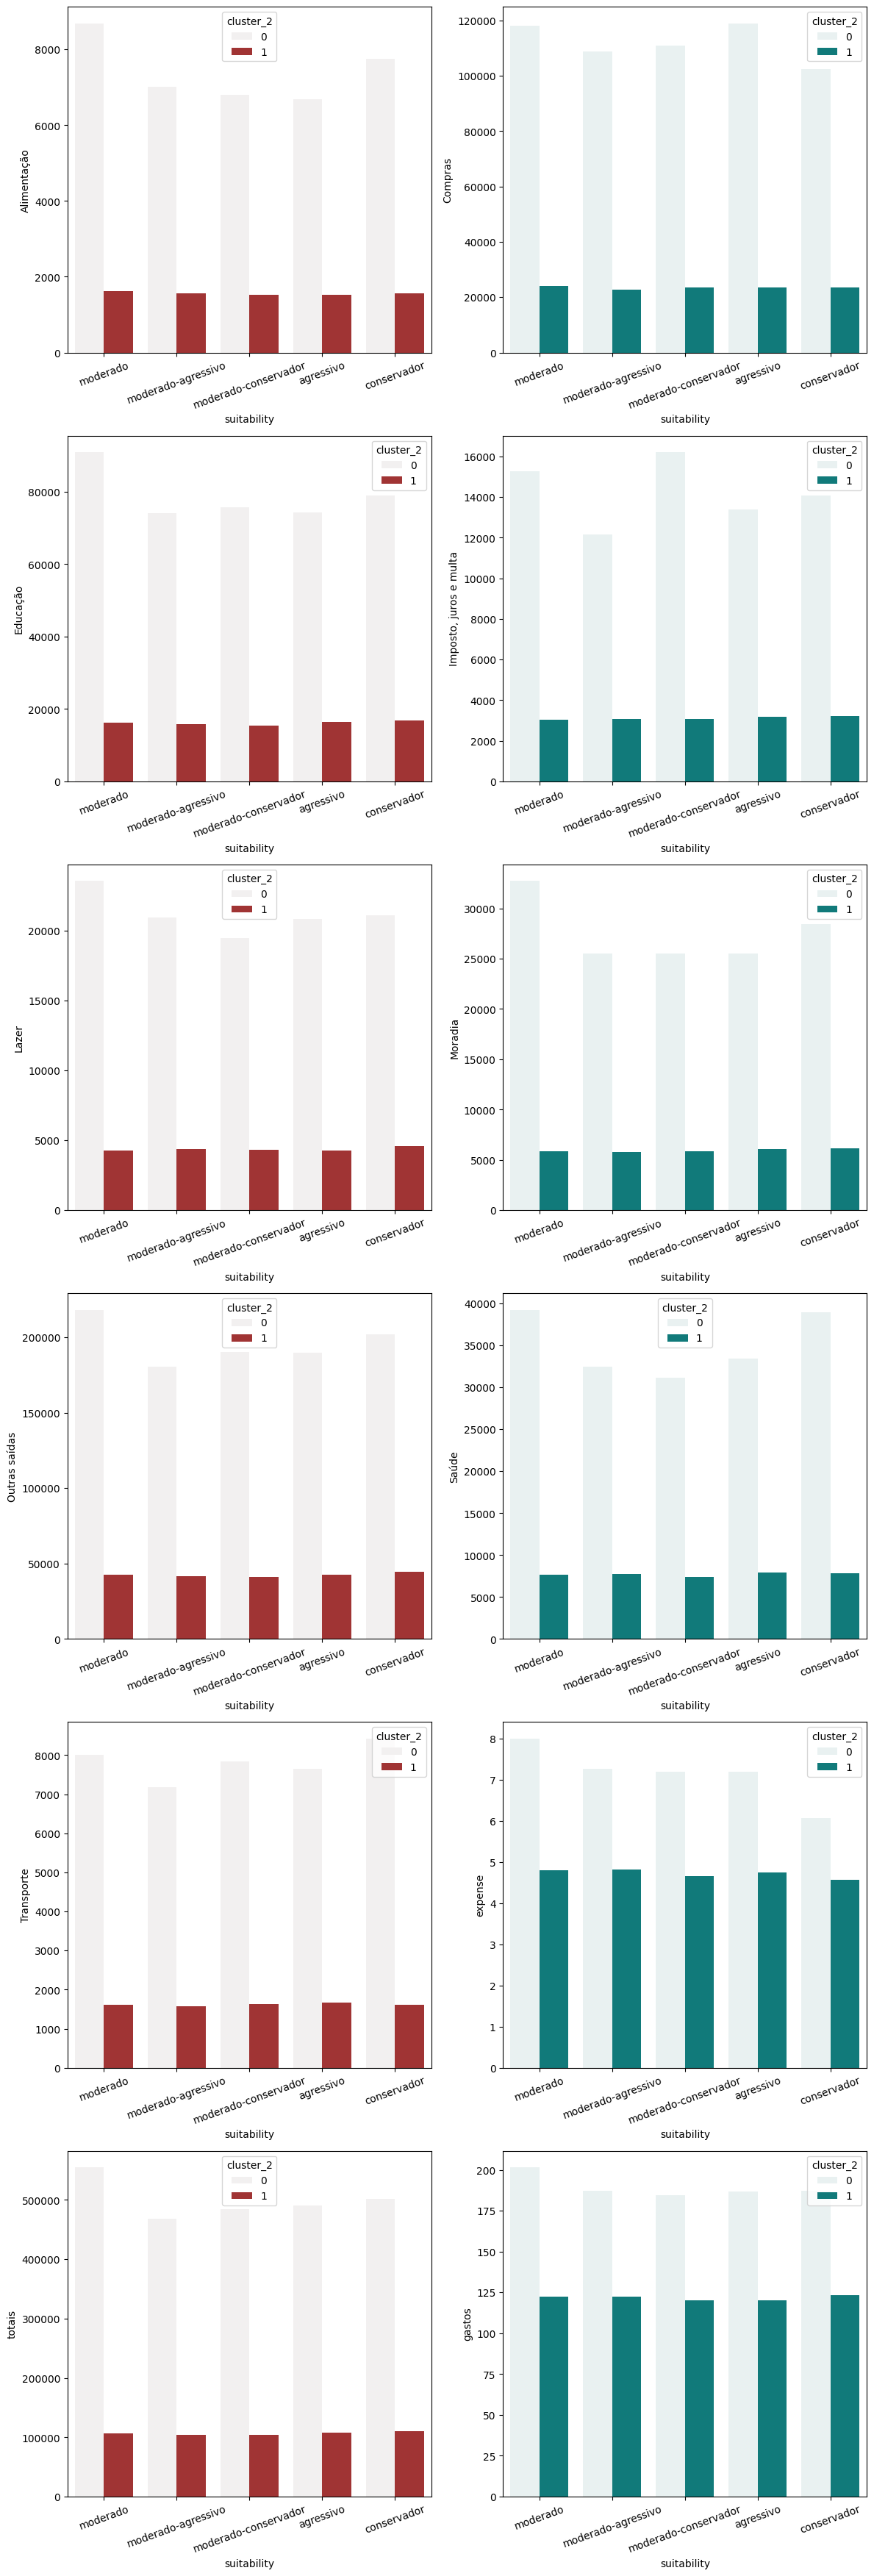

In [133]:
print('Houve uma difereça muito grande entre os clusters em relação a cada um dos parâmetros')

lista = ['amount_Alimentação', 'amount_Compras', 'amount_Educação', 
        'amount_Imposto, juros e multa', 'amount_Lazer', 'amount_Moradia', 
        'amount_Outras saídas', 'amount_Saúde', 'amount_Transporte', 
        'fixed_expense', 'gastos_totais', 'qtd_gastos_variaveis']

fig = plt.figure(figsize=(12, 40))
gs = fig.add_gridspec(int(len(lista) / 2)+1, 2)

for i in range(0, len(lista), 2):
    ax1 = fig.add_subplot(gs[int(i / 2), 0])
    sns.barplot(x='suitability', y=lista[i], data=data_total, color='firebrick', ax=ax1, hue='cluster_2', errorbar=None)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=20)
    plt.xlabel('suitability')
    plt.ylabel(lista[i].split("_")[1])

    ax2 = fig.add_subplot(gs[int(i / 2), 1])
    sns.barplot(x='suitability', y=lista[i + 1], data=data_total, color='darkcyan', ax=ax2, hue='cluster_2', errorbar=None)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=20)
    plt.xlabel('suitability')
    plt.ylabel(lista[i + 1].split("_")[1])

plt.tight_layout()
plt.show()


Juntando os dataframes para descrever os agrupamentos

In [134]:
data_total[['id_person','cluster_2']]

,id_person,cluster_2
0,000be23a-894b-4eca-aa31-5373556f8204,1
1,001de888-9b29-4b8e-95ca-59adc5903f45,1
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,0
3,007acb4a-2a68-4437-85e2-0bbda827360c,1
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,1
...,...,...
2525,ff56abfc-6694-4d34-a56c-c10187915059,1
2526,ff61dd96-5421-4461-8673-5dd8f40f8377,1
2527,ff6f6163-c1d2-4630-86aa-5d5afee4cd80,1
2528,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,1


In [135]:
df_period_acc = accounts.merge(df_period, left_on='id', right_on='account_id', suffixes=['_acc', '_trans'])

In [136]:
df_period_acc_clusters = data_total[['id_person','cluster_2']].merge(df_period_acc, left_on="id_person",
                                                                    right_on='person_id',
                                                                    suffixes=['_clu', '_period'])

In [137]:
a = df_period_acc_clusters[df_period_acc_clusters.fixed_expense == True]
b = a[(a.category != 'Recebido') & (a.category != 'Investimento')]

In [138]:
result = b.groupby(['cluster_2', 'category'])['amount'].agg(['mean', 'sum', "count"]).reset_index()
result["sum/count"] = (result['sum']/result["count"])*100
result.sort_values(['cluster_2', 'sum/count'], ascending=False)

# Proporcionamente se dividimos a soma dos gastos pelo número de gastos, podemos perceber que tanto para o Cluster 0 quanto pro 1 foram gastos mais em Compras 
# e depois em Educação

,cluster_2,category,mean,sum,count,sum/count
10,1,Compras,1679.458714,1358682.10,809,167945.871446
11,1,Educação,1241.031079,517509.96,417,124103.107914
15,1,Outras saídas,1039.378727,457326.64,440,103937.872727
16,1,Saúde,622.905990,251654.02,404,62290.599010
14,1,Moradia,438.337327,519868.07,1186,43833.732715
13,1,Lazer,365.990253,173479.38,474,36599.025316
12,1,"Imposto, juros e multa",240.461914,251282.70,1045,24046.191388
9,1,Alimentação,127.041713,82323.03,648,12704.171296
17,1,Transporte,122.624277,120417.04,982,12262.427699
1,0,Compras,6071.947238,637554.46,105,607194.723810


In [139]:
# Agrupando o DataFrame por 'cluster_2' e 'category' e calcule a soma e a contagem de 'amount'
grouped = b.groupby(['cluster_2', 'category'])['amount'].agg([sum, 'count'])

# Calculamdo o total de 'amount' para cada cluster
total_by_cluster = b.groupby('cluster_2')['amount'].agg(sum)

# Redefinindo o índice para evitar problemas de não ser único
grouped = grouped.reset_index()

# Calculando a proporção de cada categoria em relação a cada cluster
grouped['proporção'] = grouped.apply(lambda row: row['sum'] / total_by_cluster[row['cluster_2']], axis=1)

# Nomeando as colunas para algo mais descritivo
grouped = grouped.rename(columns={'sum': 'amount', 'count': 'sum'})

# O resultado agora contém o valor bruto, a proporção e o max_over_sum de cada categoria em relação a cada cluster
print(grouped)


    cluster_2                category      amount   sum  proporção
0           0             Alimentação    34162.32    77   0.023562
1           0                 Compras   637554.46   105   0.439732
2           0                Educação   154025.58    42   0.106234
3           0  Imposto, juros e multa    78960.01   113   0.054460
4           0                   Lazer    57159.98    55   0.039424
5           0                 Moradia   152812.01   119   0.105397
6           0           Outras saídas   159384.06    53   0.109930
7           0                   Saúde   130875.29    57   0.090267
8           0              Transporte    44935.35   123   0.030993
9           1             Alimentação    82323.03   648   0.022055
10          1                 Compras  1358682.10   809   0.364010
11          1                Educação   517509.96   417   0.138648
12          1  Imposto, juros e multa   251282.70  1045   0.067322
13          1                   Lazer   173479.38   474   0.04

In [140]:
# Realizando uma ANOVA para cada categoria de compra para verificar a significância estatística
for category in ['amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa', 'amount_Lazer', 
                 'amount_Moradia', 'amount_Outras saídas', 'amount_Saúde',
       'amount_Transporte']:
    groups = [data_total[data_total['cluster_2'] == i][category] for i in range(2)]  # K é o número de clusters
    F, p = f_oneway(*groups)
    print(f'Categoria: {category}, F-statistic: {F:.2f}, p-value: {p:.4f}')

# Identifique as categorias de compra com valores de p significativos
significant_categories = ['Gasto_Categoria1', 'Gasto_Categoria3']

# Um valor alto da Estatística F sugere que há diferenças significativas entre os grupos, 
# enquanto um valor baixo sugere que as médias dos grupos são semelhantes.
# Transporte e Compras são os que mais influenciam a divisão dos grupos em diferentes perfis de gastos

Categoria: amount_Alimentação, F-statistic: 2290.06, p-value: 0.0000
Categoria: amount_Compras, F-statistic: 2406.04, p-value: 0.0000
Categoria: amount_Educação, F-statistic: 2269.96, p-value: 0.0000
Categoria: amount_Imposto, juros e multa, F-statistic: 2287.53, p-value: 0.0000
Categoria: amount_Lazer, F-statistic: 2323.24, p-value: 0.0000
Categoria: amount_Moradia, F-statistic: 1996.96, p-value: 0.0000
Categoria: amount_Outras saídas, F-statistic: 2361.47, p-value: 0.0000
Categoria: amount_Saúde, F-statistic: 2222.99, p-value: 0.0000
Categoria: amount_Transporte, F-statistic: 2416.76, p-value: 0.0000


### Utilizando os algoritmos Random Forest e KNN para prever o "suitability" dos dados faltantes

In [141]:
data_total.suitability.unique()

array(['moderado', 'moderado-agressivo', 'moderado-conservador',
       'agressivo', 'conservador'], dtype=object)

In [142]:
data_total.drop(columns=['id_person']).columns.__len__()

37

In [143]:
data_total.drop(columns=['id_person']).columns

Index(['suitability', 'year_trans', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense',
       'gastos_totais', 'balance_totais', 'qtd_gastos_totais',
       'qtd_gastos_variaveis', 'cluster_2', 'cluster_3', 'cluster_4'],
      dtype='object')

In [144]:
lista = ['suitability', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense',
       'gastos_totais', 'balance_totais', 'qtd_gastos_totais',
       'qtd_gastos_variaveis']

data = data_total[lista]

data_suitability = data_total['suitability']

# Separando os dados em recursos (X) e rótulo (y)
X = data.drop('suitability', axis=1)  # Coluna 'suitability_moderado' é o rótulo
y = data_suitability

# Normalizando os dados (importante para o K-Means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# Separando os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(data_scaled, y, test_size=0.2, random_state=42)

In [145]:
# Escolhendo o modelo (Random Forest Classifier)
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42)

# Treinamento do Modelo
model_RFC.fit(X_train, y_train)

# Previsões
y_pred = model_RFC.predict(X_test)

# Avaliação do Modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

Acurácia do modelo: 0.1774580335731415
                      precision    recall  f1-score   support

           agressivo       0.17      0.24      0.20        83
         conservador       0.19      0.23      0.21        79
            moderado       0.17      0.14      0.15        93
  moderado-agressivo       0.18      0.18      0.18        84
moderado-conservador       0.18      0.10      0.13        78

            accuracy                           0.18       417
           macro avg       0.18      0.18      0.17       417
        weighted avg       0.18      0.18      0.17       417



In [146]:
# Instanciando o modelo KNN
model_KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=1)

# Treinamento do Modelo
model_KNN.fit(X_train, y_train)

# Prevendo com o modelo treinado
y_pred = model_KNN.predict(X_test)

# Avaliação do Modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))


Acurácia do modelo: 0.2278177458033573
                      precision    recall  f1-score   support

           agressivo       0.25      0.48      0.33        83
         conservador       0.21      0.30      0.24        79
            moderado       0.30      0.17      0.22        93
  moderado-agressivo       0.15      0.08      0.11        84
moderado-conservador       0.22      0.10      0.14        78

            accuracy                           0.23       417
           macro avg       0.22      0.23      0.21       417
        weighted avg       0.23      0.23      0.21       417



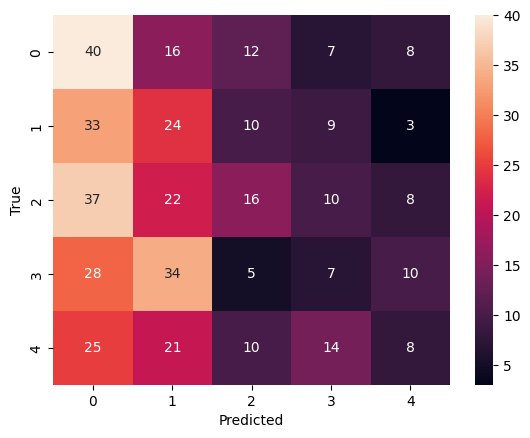

In [147]:
# Suponha que y_true seja o conjunto de rótulos reais e y_pred seja o conjunto de rótulos previstos
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [148]:
# Por conta da maior acurácia foi escolhido o modelo de KNN, mesmo que não tenha sido uma acurácia muito elevada.

lista = ['balance_Caixinha', 'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte', 'fixed_expense_Alimentação',
       'fixed_expense_Compras', 'fixed_expense_Educação',
       'fixed_expense_Imposto, juros e multa', 'fixed_expense_Investimento',
       'fixed_expense_Lazer', 'fixed_expense_Moradia',
       'fixed_expense_Outras saídas', 'fixed_expense_Recebido',
       'fixed_expense_Saúde', 'fixed_expense_Transporte', 'fixed_expense',
       'gastos_totais', 'balance_totais', 'qtd_gastos_totais',
       'qtd_gastos_variaveis']

new_data = data_no_suitability[lista]

# Usando o modelo treinado para fazer previsões de classificação para os novos dados de entrada
predicted_suitability = model_KNN.predict(new_data)

new_data['predicted_suitability'] = predicted_suitability

print(new_data.predicted_suitability.unique())

new_data


['moderado' 'conservador' 'agressivo' 'moderado-conservador']


,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,...,fixed_expense_Outras saídas,fixed_expense_Recebido,fixed_expense_Saúde,fixed_expense_Transporte,fixed_expense,gastos_totais,balance_totais,qtd_gastos_totais,qtd_gastos_variaveis,predicted_suitability
6,0.00,0.00,12208.86,0.00,8407.82,1861.52,18163.75,20247.58,3997.57,11590.66,...,43,18,17,15,2,146698.51,20616.68,184,182,moderado
10,0.00,0.00,3192.72,0.00,0.00,660.72,3455.97,4492.62,1374.61,4020.69,...,7,3,7,4,2,29611.64,3192.72,54,52,moderado
17,8230.75,8745.78,5043.64,9938.98,0.00,3449.60,52673.49,22344.18,7996.17,13961.93,...,47,22,32,20,8,182866.49,31959.15,270,262,moderado
23,0.00,0.00,0.00,243.69,13737.12,1226.57,22229.01,20783.85,2996.69,8611.93,...,20,14,14,10,8,92000.38,13980.81,130,122,moderado
26,5013.50,4307.87,674.12,2617.91,0.00,2731.30,46080.12,23485.10,7623.01,11246.56,...,46,37,18,18,6,183763.24,12613.40,235,229,moderado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,6919.41,7294.56,399.34,0.00,0.00,2023.47,51585.61,29788.11,2502.73,8285.41,...,43,23,22,32,12,188729.38,14613.31,230,218,moderado
2520,0.00,0.00,4744.70,0.00,3600.56,766.94,14340.78,17382.30,327.63,6364.45,...,25,3,2,11,1,75276.96,8345.26,80,79,moderado
2521,0.00,0.00,3415.11,0.00,0.00,1755.57,4226.97,8168.70,1461.94,2781.75,...,11,15,8,3,6,47088.94,3415.11,64,58,moderado
2524,0.00,5000.50,5079.73,0.00,0.00,1106.05,33391.92,14227.93,3116.28,11529.35,...,41,16,11,15,6,128506.01,10080.23,156,150,moderado


In [149]:
# Salvando o modelo KNN
filename = 'knn_model.sav'
pickle.dump(model_KNN, open(filename, 'wb'))

In [150]:
# load do modelo KNN
Model = pickle.load(open(filename, 'rb'))